## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

## Spatio-temporal Gassusian Process Modelling Tutorial

### Background

This notebook provides a follow-on tutorial on using Gaussian Process (GP) to infer spatio-temporal variation of sea-level change based on relative sea-level (RSL) data. Please make sure you read `PaleoSTeHM_Temporal` and `PaleoSTeHM_EIV_NI` and understand how to do temporal GP before starting this notebook.

We know that sea-level change varies not only temorally but also **spatially**, therefore incorporating spatial information into inference algorithm is an important step forward. Therefore, instead of assumping sea-level change independently at each site (i.e., sea level in different sites locate closely together can be completely different), spatio-temporal GP (SP-GP) can capture spatial information into final inference results. In other words, it assumes the nearby sea-level sites should experience similar sea-level variation compared to sites that are far away from them. And an important advantage of SP-GP is that it can infer spatio-temporal field of RSL change and therefore enable spatial analysis (c.f., temporal GP)!

As in temporal GP tutorial, we continues to use RSL data from Ashe et al., 2019 (and references therein), which they used to produce illustative spatio-temporal GP inference. Let's load the module and data first.

In [1]:
#load modules
import os
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import sys
import nmmn.plots

sys.path.append('../Code')
import PSTHM 
import time
parula=nmmn.plots.parulacmap() # for MATLAB's cmap

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

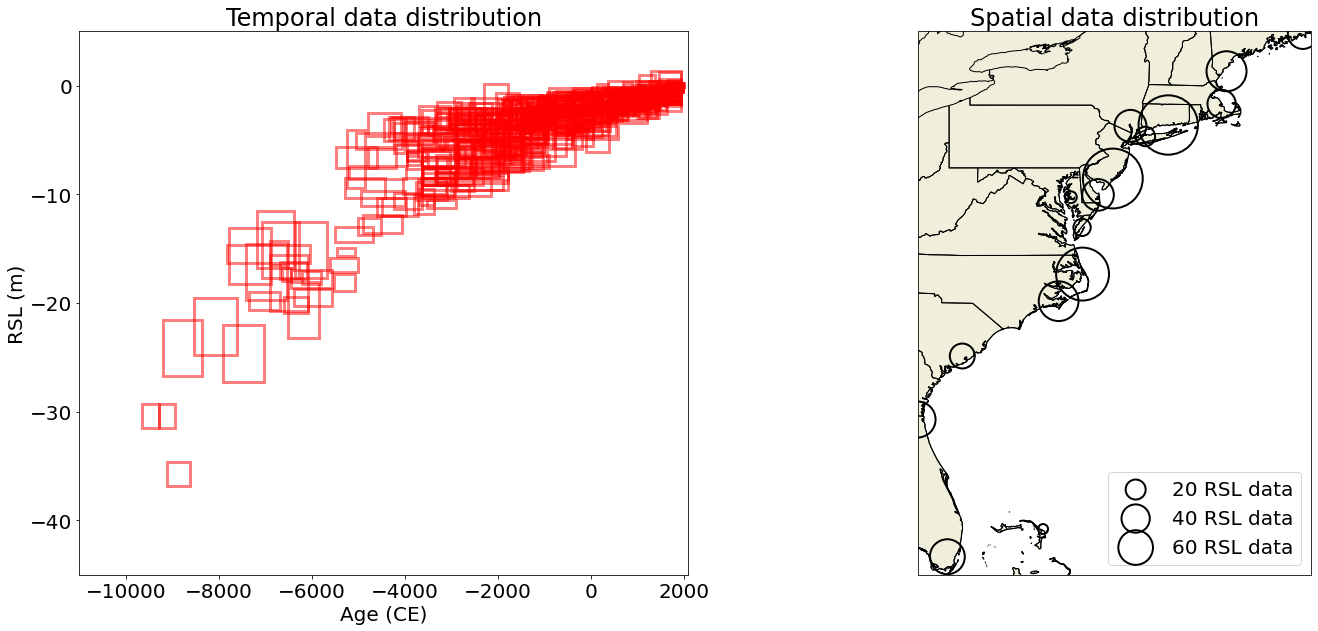

In [2]:
#load data
#ml is marine limiting data, tl is terrestrial limiting data, SLIP is sea-level index points
ml, SLIP, tl = PSTHM.load_regional_rsl_data('../Data/US_Atlantic_Coast_for_ESTGP.csv')
age, y, y_sigma, age_sigma, rsl_lon,rsl_lat, rsl_region = SLIP

rsl_coord = torch.tensor(np.vstack((rsl_lat,rsl_lon)).T)
X = torch.hstack([age[:,None],rsl_coord])

#--------Plot data distribution----------------
fig = plt.figure(figsize=(24,10))
gs = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gs[0, :1])
PSTHM.plot_uncertainty_boxes(age,y, age_sigma*2,y_sigma*2,ax=ax)
ax.set_xlim(-11000,2100)
ax.set_ylim(-45,5)
ax.set_title('Temporal data distribution')

#plot spatial data distribution, note that the size of the circle is proportional to the number of data points in the region
ax2 = fig.add_subplot(gs[0, 1:2], projection=ccrs.PlateCarree())

ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
ax2.set_extent([np.min(rsl_lon),np.max(rsl_lon),np.min(rsl_lat),np.max(rsl_lat)])
rsl_region_index = [np.where(rsl_region==i)[0] for i in np.unique(rsl_region)]
ax2.scatter([np.mean(rsl_lon[x]) for x in rsl_region_index], [np.mean(rsl_lat[x]) for x in rsl_region_index],
           transform=ccrs.PlateCarree(),s=[len(x)*20 for x in rsl_region_index],marker='o',facecolor='none',ec='k',
           linewidth=2)
sc = ax2.scatter([0],[0],s=400,label='20 RSL data',marker='o',facecolor='none',ec='k',zorder=-20,
           linewidth=2)
sc2 = ax2.scatter([0],[0],s=800,label='40 RSL data',marker='o',facecolor='none',ec='k',zorder=-20,
           linewidth=2)
sc3 = ax2.scatter([0],[0],s=1200,label='60 RSL data',marker='o',facecolor='none',ec='k',zorder=-20,
           linewidth=2)

ax2.legend(handles=[sc,sc2,sc3], labels=['20 RSL data','40 RSL data','60 RSL data'], loc = 4)

ax2.set_title('Spatial data distribution');

From the left plot, you might find the RSl data is much noisier compared to New Jersey data, which reflects spatial variability across the East coast of the US. On the right hand site you can find the spatial location of RSL site with point size indicating the number of data from that region. 

Like temporal GP tutorial, in this tutorial we will go through ST GP with different levels of complexity:

&#10148; 1. Inferring spatio-temporal sea-level change using RSL data from multiple sea-level sites, assuming no temporal uncertainty, with a single spatial and temporal scale GP kernel.

&#10148; 2. Inferring spatio-temporal sea-level change using RSL data from multiple sea-level sites, incorporating data temporal uncertainty, with a single spatial and temporal scale GP kernel.

&#10148; 3. Inferring spatio-temporal sea-level change using RSL data from multiple sea-level sites, assuming no temporal uncertainty, with multiple spatial and temporal scale GP kernels.

&#10148; 4. Inferring spatio-temporal sea-level change using RSL data from multiple sea-level sites, incorporating data temporal uncertainty, with multiple spatial and temporal scale GP kernels.


### 1. Inferring spatio-temporal sea-level change using RSL data from multiple sea-level sites, assuming no temporal uncertainty, with a single spatial and temporal scale GP kernel.

#### Coupling spatial and temporal GP kernel

##### Incorporating spatial imformation into a GP kernel

To start let's think about how should we incorporate spatial information into account. A stratightforward way is to use longitude and latitude values as two input variables to GP regression, however, the distance calculated between longitude and latitude can be problematic since Earth is actually a sphere instead of a plate. For example, the distance between (19 $\degree$ W, 1 $\degree$ N) and (20 $\degree$ W, 1 $\degree$ N) is 1 $\degree$, and the distance between (19 $\degree$ W, 80 $\degree$ N) and (20 $\degree$ W, 80 $\degree$ N) is $\degree$ is also one degree. But in actually world, the former distance is around 111.3 km and the latter distance is only 19.4 km! In this case, it's not a good idea to use longitude and latitude here.

Instead, we can use the true geographical distance between each two data points to construct a covariance matrix, which can therefore capture their correlation purely based on their geographical proximity. In this case, a spatial RBF kernel can be written as 

$$
k_{RBF}(x,x') = \sigma^2\exp\left(-0.5 \times \frac{|x-x'|^2}{l^2}\right)
$$

where $|x-x'|^2$ denotes squared geographical distance between each pair of data point based on their longitudes and latitudes. Note, in PaleoSTeHM package, we use radiance distance, meaning the distance from the south pole to the north pole is 3.14 (i.e., $\pi$). The true geographical distance can be obtained by timing it with 6371 (i.e., Earth's radius). You can define a spatial kernel quitely easily using our PSTHM module:

```python 
spatial_RBF_kernel = global_kernel = PSTHM.RBF(input_dim=1,geo=True)
```

By setting `geo=True`, the code can compute a RBF kernel for you based on geographical distance. For spatial kernels, there are five options in PSTHM module:

**&#10148; 1.** RBF

**&#10148; 2.** RationalQuadratic

**&#10148; 3.** Exponential

**&#10148; 4.** Matern32

**&#10148; 5.** Matern52 

The only difference between them and the kernels we introduced in temporal GP tutorial is that they can calculate covariance function based on geographical distance. Note, the input for these kernels should have three columns [Age, Latitude, Longitude]. And if you set `geo=False`, the covariance function will be calculated based on the age column.

##### Coupling spatio-temporal GP kernels

Once we know how to construction a spatial kernel, coupling it with a temporal kernel is very easy: 

$$
k_{RBF}(X,X') = \sigma^2 \exp\left(-0.5 \times \frac{|t-t'|^2}{l_{t}^2}\right) \times \exp\left(-0.5 \times \frac{|x-x'|^2}{l_{s}^2}\right)
$$

where $X$ is a data matrix contains age and geographical location of each data, $\sigma^2$ is a varaince hyperparameter that controls the variability of this covariance function. $l_{t}$ and $l_{s}$ are length scale hyperparameters that deteremines the temporal and spatial length scale of covariance function. For example, if $l_{s}$ is large, we expect a larger nearby area to share a similar RSL variation pattern and vice versa. Becuase we are constructing spatio-temporal kernel here, the input data should incorporate spatio-temporal information like:

| Age (CE)  | Laitude (degree) | Longitude (degree)  |
| :-: | :-: | :-: |
| -2576 | 44.629 | -67.382
| -2607 | 44.429 | -68.-1
| ... | ... | ...


Ok, let's try it!



In [3]:
st = time.time() 
pyro.clear_param_store() 

#construct spatial and temporal kernels
spatial_RBF_kernel = PSTHM.RBF(input_dim=1,geo=True)
#note the spatial lengthscale is called s_lengthscale in the PSTHM package
#you can time spatial lengthscale hyperparameter with 6371 to get the geographical distance in km
spatial_RBF_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.01), torch.tensor(0.3)))

temporal_RBF_kernel = PSTHM.RBF(input_dim=1,geo=False)
temporal_RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(3000.)))
temporal_RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-3), torch.tensor(1000.)))

#couple spatial and temporal kernels 
ST_RBF_kernel = gp.kernels.Product(spatial_RBF_kernel, temporal_RBF_kernel)

#build a GP regressor with the combined kernel, assuming no chronological uncertainty
gpr = PSTHM.GPRegression_V(X, y, ST_RBF_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.SVI_optm(gpr,lr=0.075,num_iteration=500)

#predict RSL for each rsl data age 
pred_y,_ = gpr(gpr.X, full_cov=True) 

#calulate log likelihood of the model prediction
fit_likelihood = PSTHM.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))


  0%|          | 0/500 [00:00<?, ?it/s]

Log Likelihood 168.671
Execution time: 31.174 s


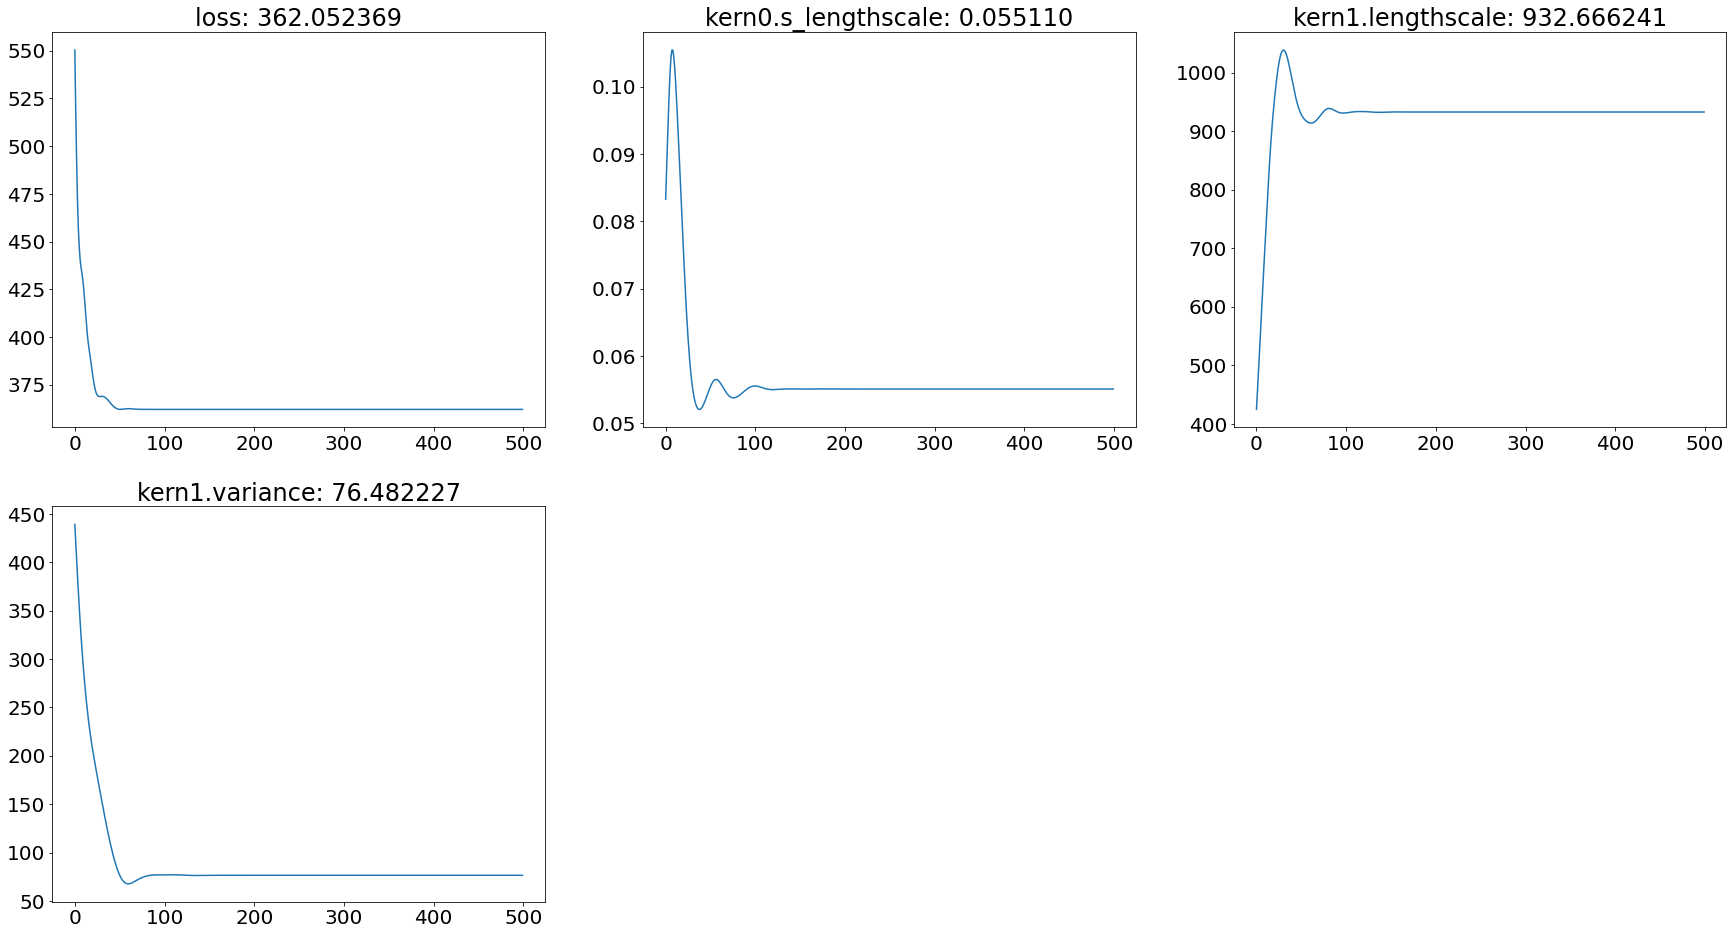

In [6]:
axes = PSTHM.plot_track_list(track_list)    

Ok, it seems the hyperparameters are concerged pretty well, we can start to generate some inferences on spatio-temporal sea-level change now. To predict RSL, we need to provide an input matrix with the same format as the input data. Let's try to predict a temporal RSL variation for New Jersey first. 

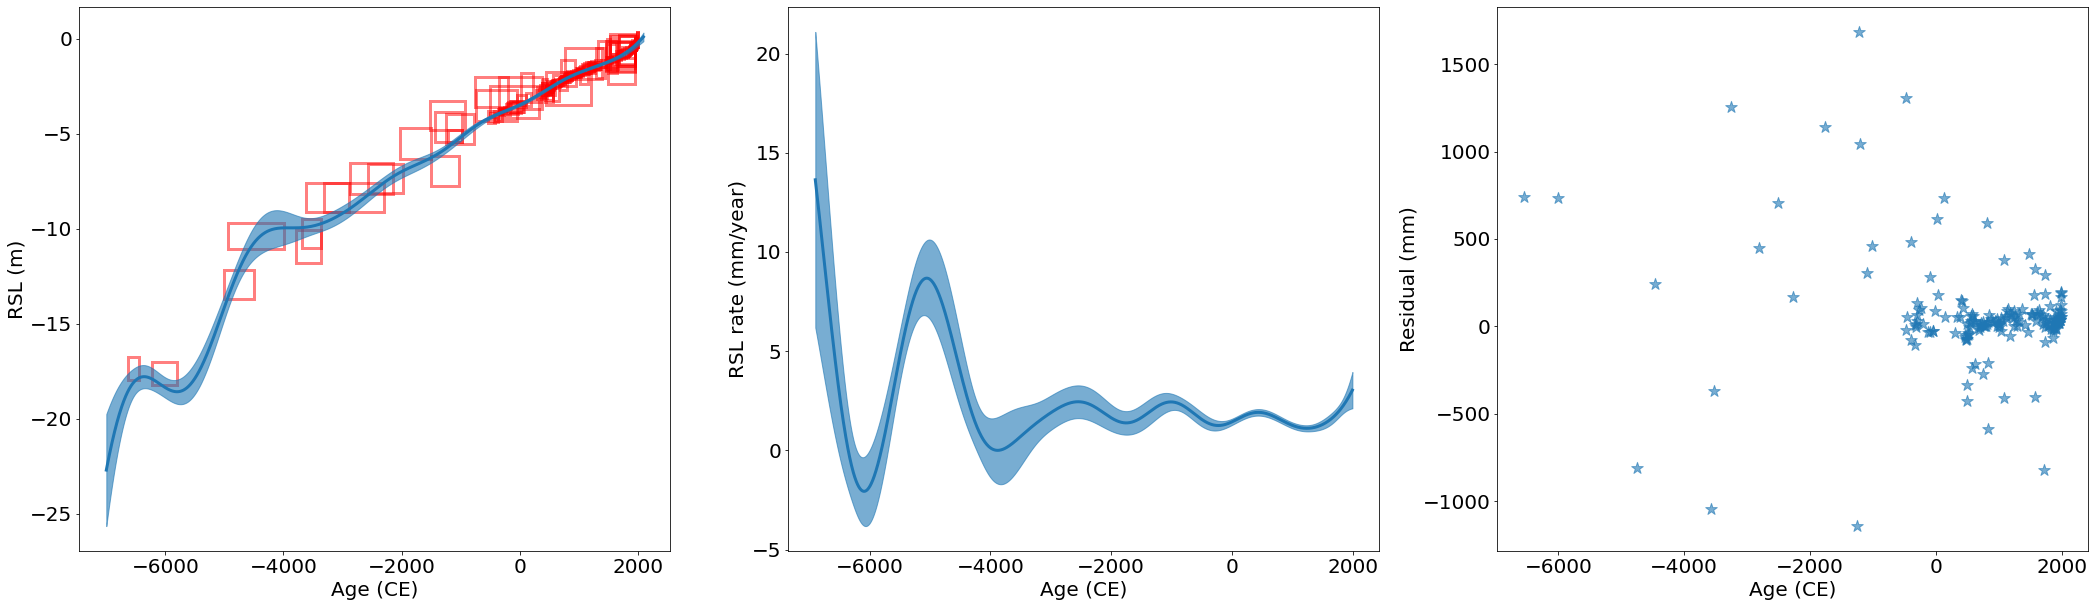

In [7]:
#generate prediction matrix
NJ_index = rsl_region==7
test_age = np.arange(-7000,2100,5)
pred_matrix = PSTHM.gen_pred_matrix(test_age,np.mean(rsl_lat[NJ_index]),np.mean(rsl_lon[NJ_index]))
y_mean, y_var = gpr(pred_matrix.double(), full_cov=True)
y_std = y_var.diag().sqrt()
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.cal_rate_var(test_age,y_var.detach().numpy(),y_mean.detach().numpy())

#plot the prediction
axes = PSTHM.plot_tem_regreesion(age[NJ_index],y[NJ_index],age_sigma[NJ_index],y_sigma[NJ_index],test_age,y_mean,y_std,
                          rsl_time,rsl_rate,rsl_rate_sd )


Seems not bad! Because we are using the RBF kernel, RSL changes quite smoothly here. Let's now try to predict spatial pattern of RSL. For sea-level study, visulising the sea-level change rate plot is often more meaningful compared with plotting a single time slice. So let's try plot RSL difference from 10000 to 6000 CE like Fig. 5 in [Ashe et al., 2019](https://www.sciencedirect.com/science/article/pii/S0277379118302130#fig5), which can tell us about the mean RSL between them, RSL change rate, and the uncertainty.  

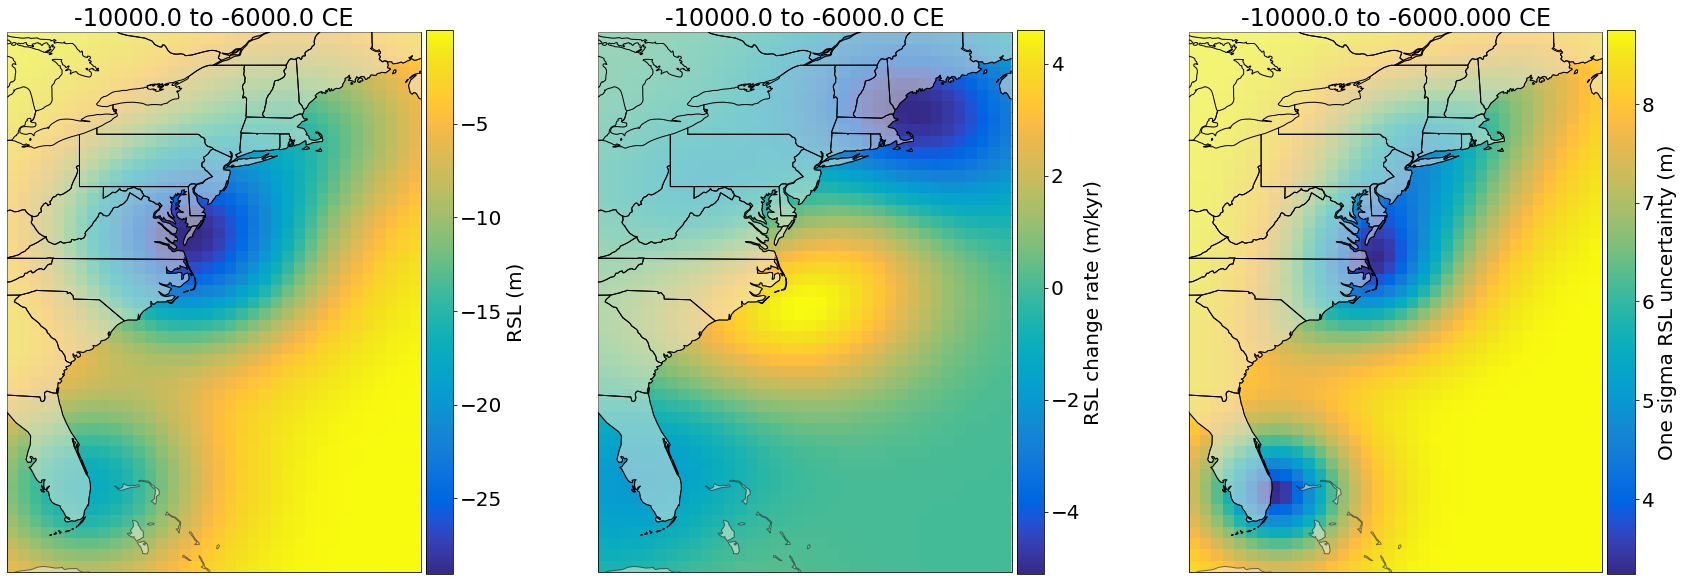

In [4]:
lat_matrix = np.arange(np.min(rsl_lat)-2,np.max(rsl_lat)+2,0.5)
lon_matrix = np.arange(np.min(rsl_lon)-2,np.max(rsl_lon)+2,0.5)
#from 10000 to 8000 with 500 years interval, don't use over small time interval, otherwise the prediction will be very slow
#and the required RAM will be pretty large 
time_mat = np.arange(-10000,-5900,2000) 
pred_matrix = PSTHM.gen_pred_matrix(time_mat,lat_matrix,lon_matrix)
y_mean, y_var = gpr(pred_matrix, full_cov=True)

PSTHM.plot_spatial_rsl_range(pred_matrix,y_mean,y_var,rsl_lon,rsl_lat,age,rsl_region,cmap=parula,plot_site=True)

### 2. Inferring spatio-temporal sea-level change using RSL data from multiple sea-level sites, incorporating data temporal uncertainty, with a single spatial and temporal scale GP kernel.

Ok, let's now considering the temporal uncertainty using noisy-input GP method as we introduced in temporal Gaussian Process tutorial. Thanks to the auto-differentiation function by pytorch, NI-GP is pretty easy to implement for SP-GP as well, you can simply change Empirical Bayes hyperparameter optimization function from `PSTHM.SVI_optm` to `PSTHM.SVI_NI_optm`.

Note that because we are dealing with much older data here (c.f., from -2000 CE in temporal regression notebook), temporal uncertainty becomes pretty large (e.g., larger than a thousand year). In this case, to iteratively update temporal uncertainty into vertical uncertainty (i.e., NI_GP), we need to use a lower learning rate along with a higher update frequency (e.g., update for every 20 iteration, compared with 100 in late Holocene temporal regression).

In [7]:
st = time.time() 
pyro.clear_param_store() 

#construct spatial and temporal kernels
spatial_RBF_kernel = PSTHM.RBF(input_dim=1,geo=True)
#note the spatial lengthscale is called s_lengthscale in the PSTHM package
#you can time spatial lengthscale hyperparameter with 6371 to get the geographical distance in km
spatial_RBF_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.01), torch.tensor(0.3)))

temporal_RBF_kernel = PSTHM.RBF(input_dim=1,geo=False)
temporal_RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(3000.)))
temporal_RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-3), torch.tensor(1000.)))

#couple spatial and temporal kernels 
ST_RBF_kernel = gp.kernels.Product(spatial_RBF_kernel, temporal_RBF_kernel)

#build a GP regressor with the combined kernel, assuming no chronological uncertainty
gpr = PSTHM.GPRegression_V(X, y, ST_RBF_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, note the setting here is different compared to late Holocene temporal regression
gpr,track_list = PSTHM.SVI_NI_optm(gpr,x_sigma=age_sigma,num_iteration=500,lr=0.05,decay_r=0.8)

#predict RSL for each rsl data age 
pred_y,_ = gpr(gpr.X, full_cov=True) 

#calulate log likelihood of the model prediction
fit_likelihood = PSTHM.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))


  0%|          | 0/500 [00:00<?, ?it/s]

Log Likelihood -4.295
Execution time: 65.913 s


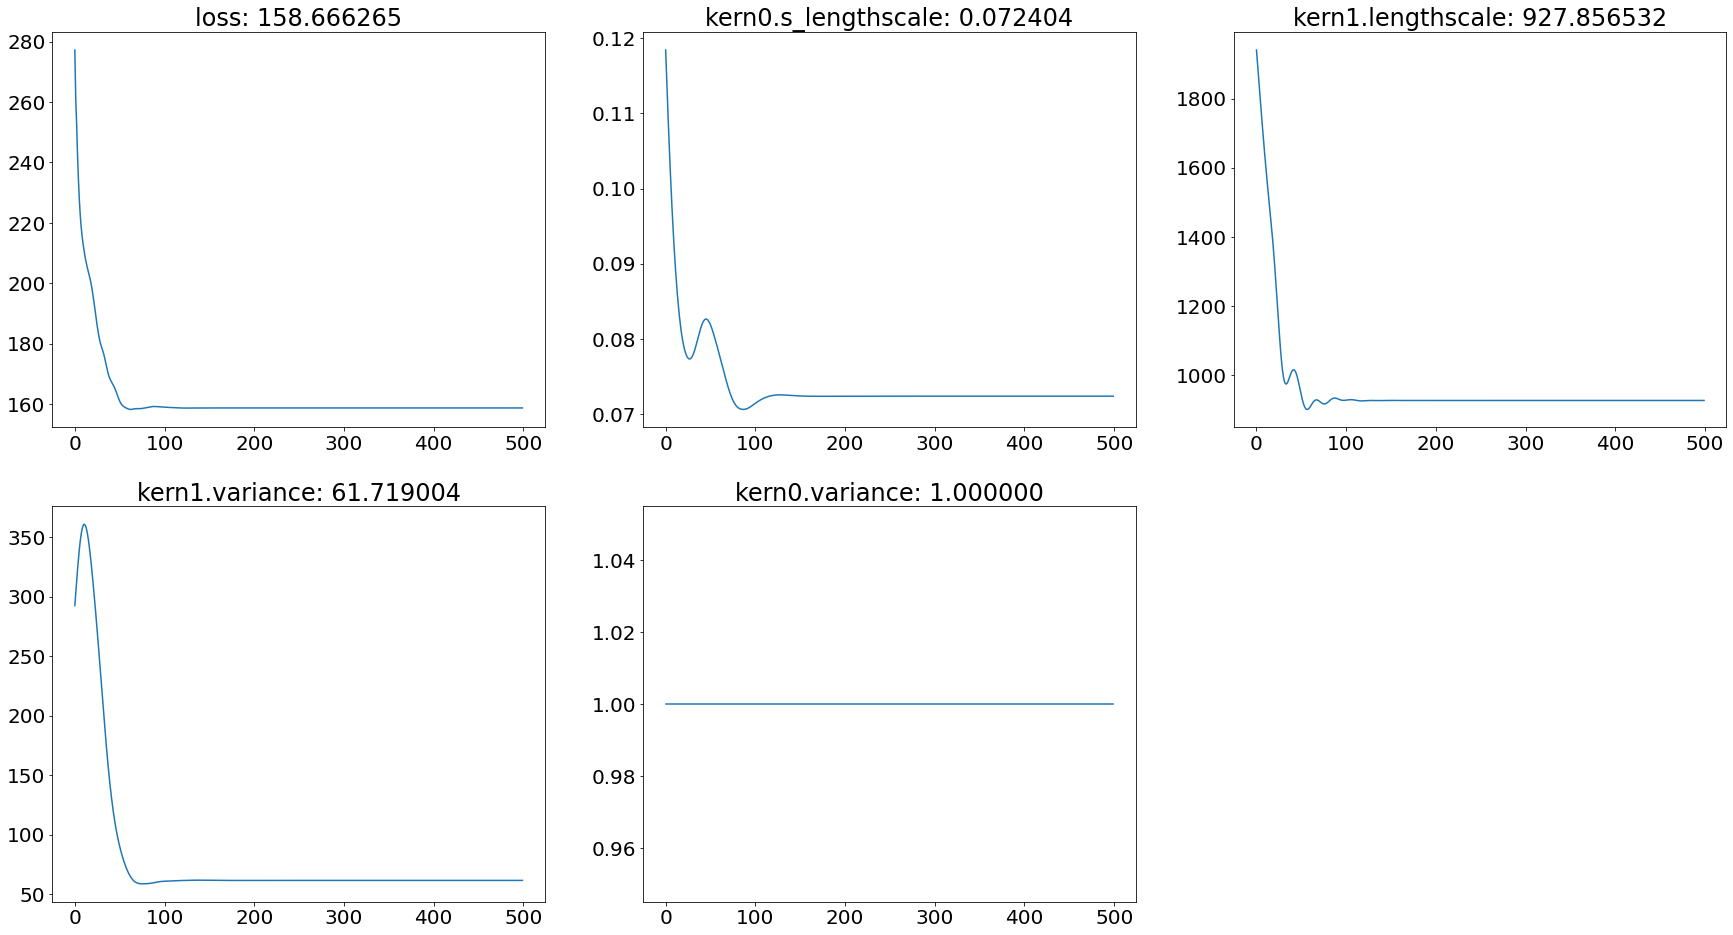

In [8]:
axes = PSTHM.plot_track_list(track_list)

If you find any tracking curves to be wiggly at the end, they can be explained by updating the RSL change rate for NI-GP method. This wiggle effect can be efficiently reduced by reducing the learning rate of optimization function (i.e., lr above).


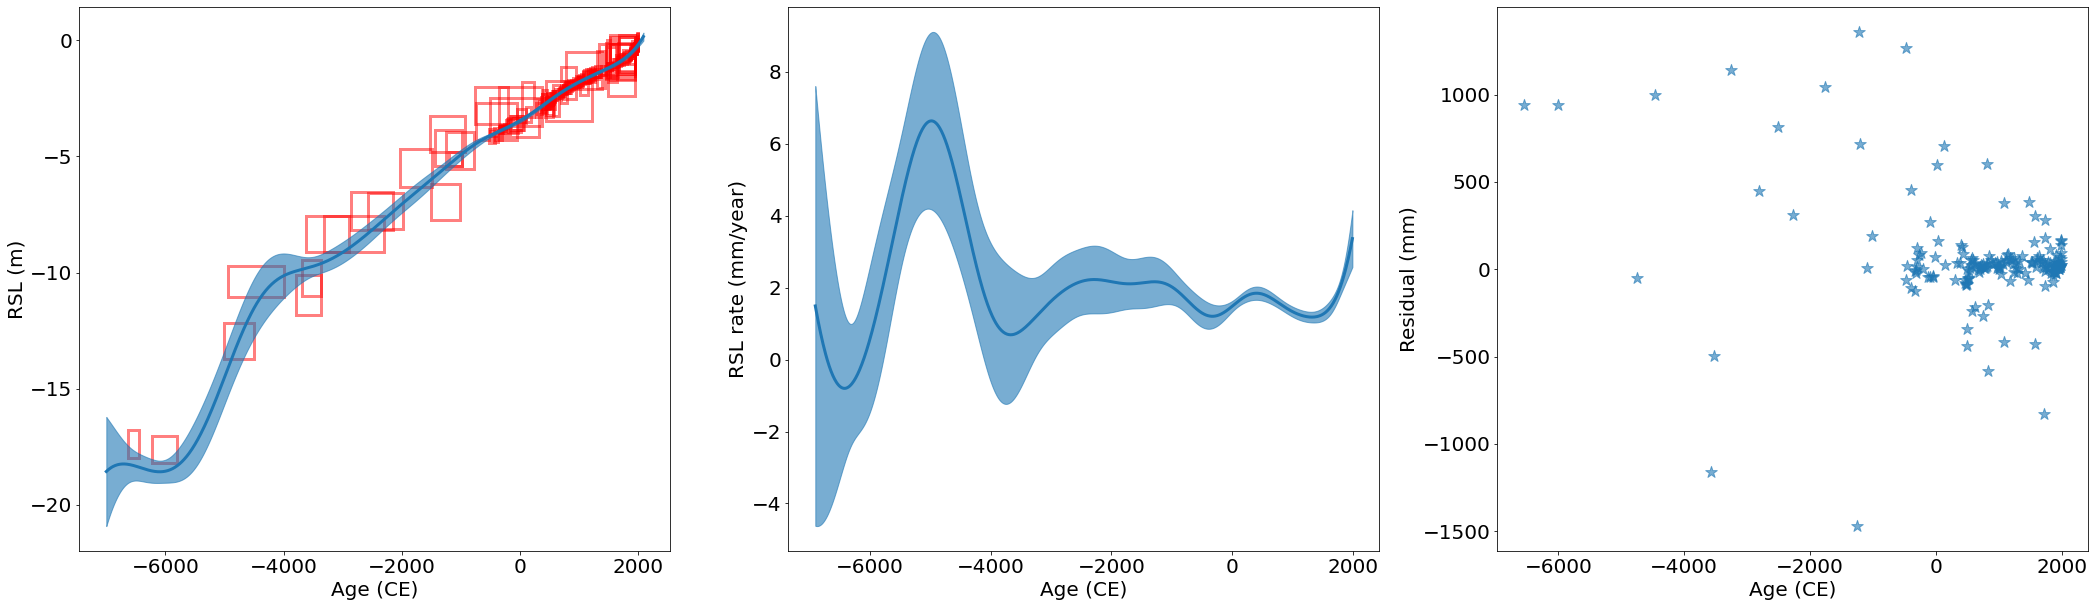

In [9]:
#generate prediction matrix
NJ_index = rsl_region==7
test_age = np.arange(-7000,2100,10)
pred_matrix = PSTHM.gen_pred_matrix(test_age,np.mean(rsl_lat[NJ_index]),np.mean(rsl_lon[NJ_index]))
y_mean, y_var = gpr(pred_matrix, full_cov=True)
y_std = y_var.diag().sqrt()
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.cal_rate_var(test_age,y_var.detach().numpy(),y_mean.detach().numpy())

#plot the prediction
axes = PSTHM.plot_tem_regreesion(age[NJ_index],y[NJ_index],age_sigma[NJ_index],y_sigma[NJ_index],test_age,y_mean,y_std,
                          rsl_time,rsl_rate,rsl_rate_sd);


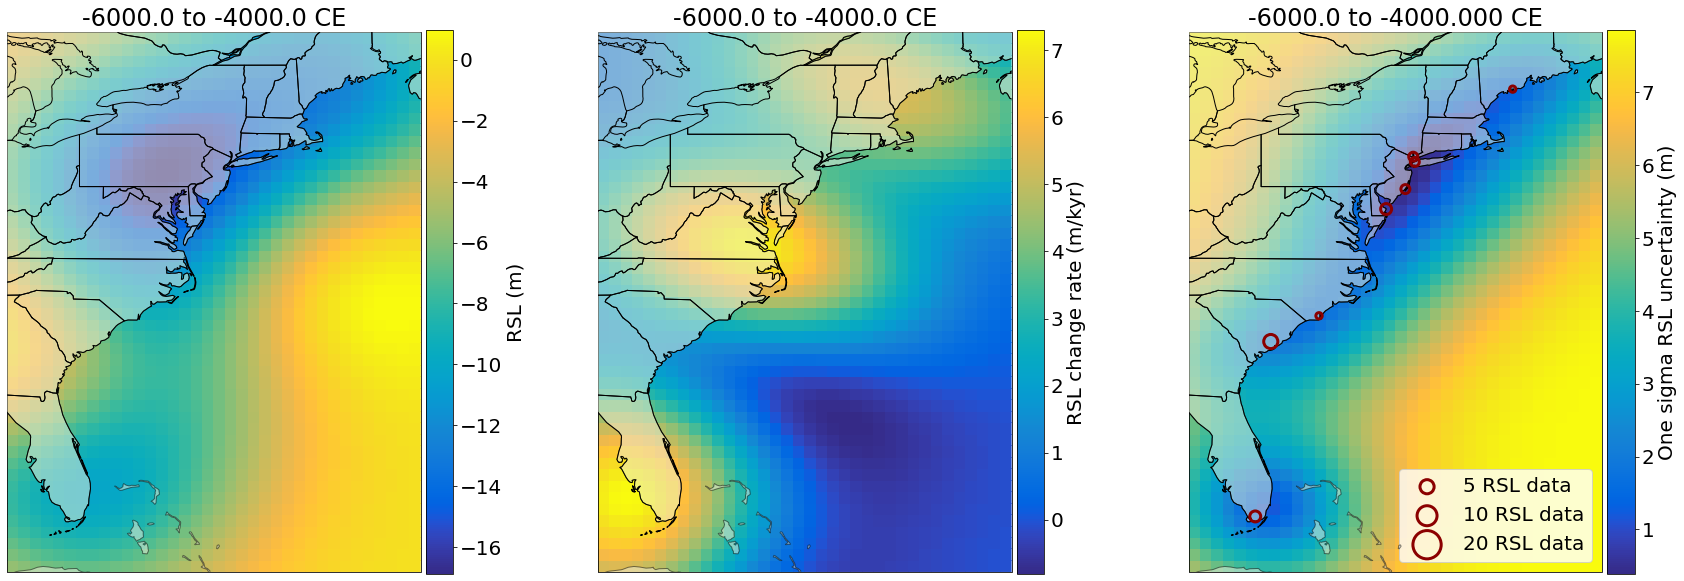

In [12]:
lat_matrix = np.arange(np.min(rsl_lat)-2,np.max(rsl_lat)+2,0.5)
lon_matrix = np.arange(np.min(rsl_lon)-2,np.max(rsl_lon)+2,0.5)
#from 10000 to 8000 with 500 years interval, don't use over small time interval, otherwise the prediction will be very slow
#and the required RAM will be pretty large 
time_mat = np.arange(-6000,-3900,1000) 
pred_matrix = PSTHM.gen_pred_matrix(time_mat,lat_matrix,lon_matrix)
y_mean, y_var = gpr(pred_matrix, full_cov=True)

PSTHM.plot_spatial_rsl_range(pred_matrix,y_mean,y_var,rsl_lon,rsl_lat,age,rsl_region,cmap=parula,plot_site=True)

### 3. Inferring spatio-temporal sea-level change using RSL data from multiple sea-level sites, assuming no temporal uncertainty, with multiple spatial and temporal scale GP kernels.

Recall "A single GP with a parametric covariance function is rarely implemented in the spatio-temporal RSL modeling literature, because a single scale of temporal variability and a single scale of spatial variability is too simple to capture physical behavior. More physical insight recognizes that RSL should have multiple spatio-temporal scales of variability, and can therefore be represented as the sum of multiple terms with GP priors." from [Ashe et al., 2019](https://www.sciencedirect.com/science/article/pii/S0277379118302130#fig5). 

Let start with an example to use multiple spatio-temporal scale GP kernels to infer RSL change pattern using tide gauage data (which essentially does not contain temporal uncertainty). To illustrate, we use tide gauge data for  US Atlantic coast from [PSMSL](https://psmsl.org) (data downloaded at 07/26/2023). Because the original data are quite noisy, we appiled a few filters to find out data that at least cover 30 year time span and they should be active now. Also, we assume the last observation of RSL is 0, and readjust the data based on that reference point.  



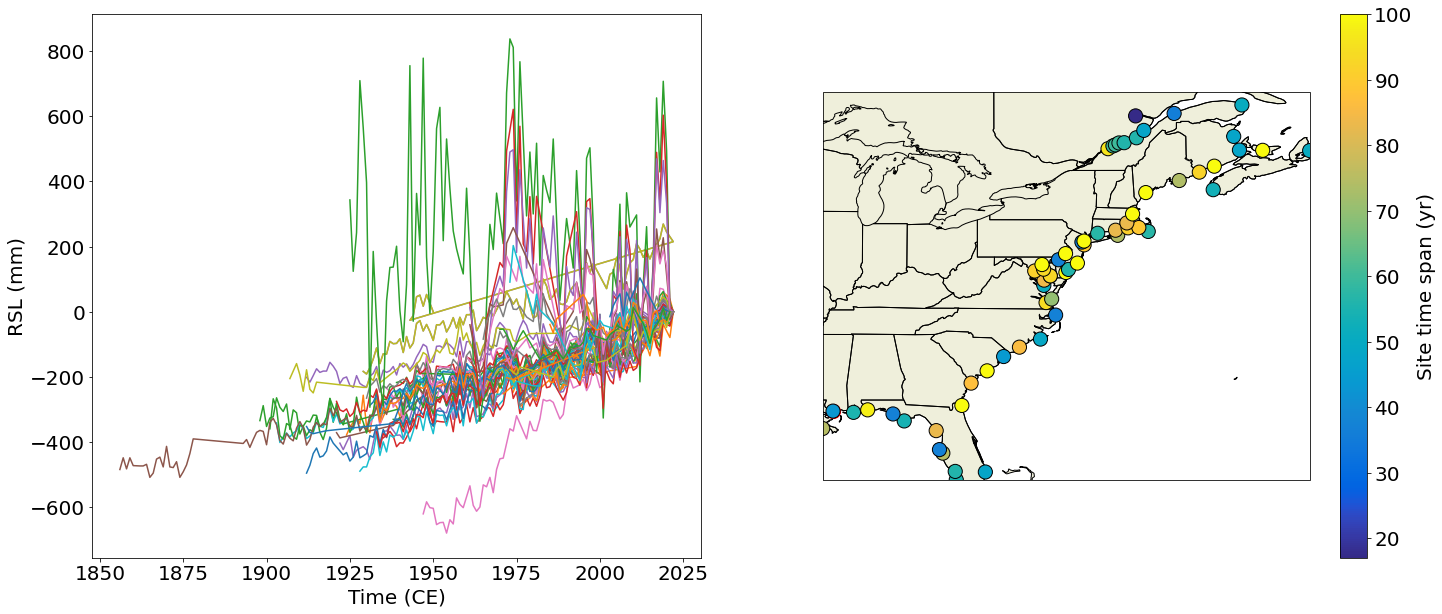

In [3]:
# #load the data, you need to define the region of interest, the minimum time span of the data, and selected data should contain data later than the latest age
US_AT_data = PSTHM.load_PSMSL_data('../Data/TG_data',min_lat=25,max_lat=50,min_lon=-90,max_lon=-60,min_time_span=30,latest_age=2020)
US_site_coord = np.unique(US_AT_data.iloc[:,4:],axis=0)
TG_X = torch.tensor(np.vstack((US_AT_data.iloc[:,4],US_AT_data.iloc[:,5])).T)
TG_X = torch.hstack([torch.tensor(US_AT_data.iloc[:,:1].values),TG_X])
TG_y = torch.tensor(US_AT_data.iloc[:,1].values)
#-----------------plot the US Atlantic Coast RSL data-----------------
fig = plt.figure(figsize=(24,10))
gs = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gs[0, :1])
for i in range(len(US_site_coord)):
    site_index = np.sum(US_AT_data.iloc[:,4:],axis=1) == np.sum(US_site_coord[i])
    ax.plot(US_AT_data[site_index].iloc[:,0],US_AT_data[site_index].iloc[:,1])
plt.xlabel('Time (CE)')
plt.ylabel('RSL (mm)')
#plot spatial data distribution, note that the size of the circle is proportional to the number of data points in the region
ax2 = fig.add_subplot(gs[0, 1:2], projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
ax2.set_extent([np.min(US_site_coord[:,1]),np.max(US_site_coord[:,1]),np.min(US_site_coord[:,0]),np.max(US_site_coord[:,0])])
site_time_length = []
for i in range(len(US_site_coord)):
    site_index = np.sum(US_AT_data.iloc[:,4:],axis=1) == np.sum(US_site_coord[i])
    site_time_length.append(np.max(US_AT_data[site_index].iloc[:,0])-np.min(US_AT_data[site_index].iloc[:,0]))
ax2.scatter(US_site_coord[10,1],US_site_coord[10,0],s=200,color='r')
im = ax2.scatter(US_site_coord[:,1],US_site_coord[:,0],c= site_time_length,
            s=200,transform=ccrs.PlateCarree(),zorder=1,vmax=100,cmap=parula,ec='k')
plt.colorbar(im,label='Site time span (yr)');

From the plots above, you can clearly see some RSL change variability across different locations. To infer the spatio-temporal RSL change pattern based on this data, here we characterize the RSL change process with three GP kernels:

$$
k(X,X') = k_{global}(t,t')+ k_{linear}(X,X')+k_{nonlin}(X,X')
\\

k_{global}(t,t') = k_{M3}(t,t')
\\

k_{linear}(X,X') = k_{Linear}(t,t') \times k_{M5}(x,x')
\\

k_{nonlin}(X,X') = k_{M3}(t,t') \times k_{M5}(x,x')
$$

where X indicates a data matrix contains age and coordinate of each data, with t representing the age and x representing the coordinate. `k` indicates the kernel (or covariance function) with $k_{Linear}$, $k_{M3}$ and $k_{M5}$ denotes linear, 3/2 Matérn and 5/2 Matérn kernels, respectively. This is a common way to describe spatio-temporal RSL process as in [Kopp et al., (2014)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014EF000239), [Kopp et al., (2016)](https://www.pnas.org/doi/abs/10.1073/pnas.1517056113). 

Now even we only consider Atlantic coast data, we have 4000+ data, so the calculation can be pretty slow (200 iterations took me 8 mintues on a fairly good desktop). Let's try to do it here:


In [4]:
# st = time.time() 
# pyro.clear_param_store()
# #define global temporal kernel
# global_kernel = PSTHM.Matern32(input_dim=1,geo=False)
# global_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(30.), torch.tensor(100000.)))
# global_kernel.set_prior("variance", dist.Uniform(torch.tensor(40.**2), torch.tensor(100000.)))

# #define regionally linar spatio-temporal kernel
# regional_linear_temporal_kernel = gp.kernels.Linear(input_dim=1)
# regional_linear_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-12), torch.tensor(1e-2)))
# regional_linear_spatial_kernel = PSTHM.Matern52(input_dim=1,geo=True)
# regional_linear_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.05), torch.tensor(0.3)))
# regional_linear_kernel = gp.kernels.Product(regional_linear_temporal_kernel, regional_linear_spatial_kernel)

# #define regionally non-linar spatio-temporal kernel
# regional_nl_temporal_kernel = PSTHM.Matern32(input_dim=1,geo=False)
# regional_nl_temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(5.), torch.tensor(5000.)))
# regional_nl_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.01), torch.tensor(40.**2)))
# regional_nl_spatial_kernel = PSTHM.Matern52(input_dim=1,geo=True)
# regional_nl_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.05), torch.tensor(0.3)))
# regional_nl_kernel = gp.kernels.Product(regional_nl_temporal_kernel, regional_nl_spatial_kernel)

# combined_sp_kernel = gp.kernels.Sum(global_kernel,regional_linear_kernel)
# combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,regional_nl_kernel)

# #-----------------define the model-----------------
# #If you don't set the noise, the model will automatically estimate the noise as the last hyperparameter
# gpr = PSTHM.GPRegression_V(TG_X, TG_y, combined_sp_kernel)


# #Empirical bayes optimization, default iteration is 1000
# gpr,track_list = PSTHM.SVI_optm(gpr,lr=0.5,num_iteration=100)

# #predict RSL for each rsl data age 
# pred_y,_ = gpr(gpr.X, full_cov=True) 


# et = time.time() # get the end time

# # get the execution time
# elapsed_time = et - st
# print('Execution time: {:3.3f} s'.format(elapsed_time))


# #----Save and load the trained model----
# torch.save(gpr, '../Trained_Models/TG_SP_model2')
gpr = torch.load('../Trained_Models/TG_SP_model2')


In [ ]:
axes = PSTHM.plot_track_list(track_list)

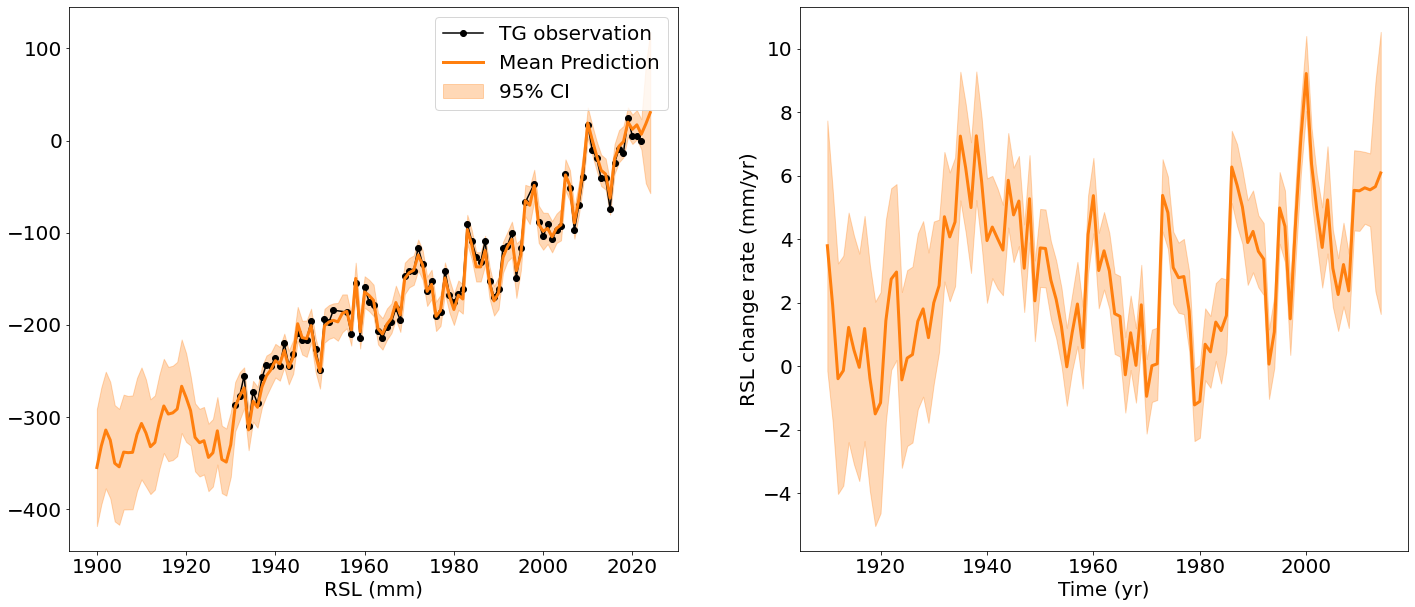

In [15]:
#generate prediction matrix
site = 40
site_index = np.sum(US_AT_data.iloc[:,4:],axis=1) == np.sum(US_site_coord[site])
test_age = np.arange(1900,2025,1)
pred_matrix = PSTHM.gen_pred_matrix(test_age,US_site_coord[site][0],US_site_coord[site][1])
y_mean, y_var = gpr(pred_matrix.double(), full_cov=True,noiseless=True)
y_std = y_var.diag().sqrt()
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.cal_rate_var(test_age,y_var.detach().numpy(),y_mean.detach().numpy(),difftimestep=20)

#plot the prediction
fig = plt.figure(figsize=(24,10))
plt.subplot(121)
plt.plot(US_AT_data[site_index].iloc[:,0],US_AT_data[site_index].iloc[:,1],'ko-',label='TG observation')
plt.plot(test_age,y_mean.detach().numpy(),color='C1',linewidth=3,label='Mean Prediction')
plt.fill_between(test_age,y_mean.detach().numpy()-2*y_std.detach().numpy(),y_mean.detach().numpy()+2*y_std.detach().numpy(),color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.xlabel('RSL (mm)')
plt.legend()
plt.subplot(122)
plt.plot(rsl_time,rsl_rate,'C1',linewidth=3,label='Mean Prediction')
plt.fill_between(rsl_time,rsl_rate-2*rsl_rate_sd,rsl_rate+2*rsl_rate_sd,color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL change rate (mm/yr)');


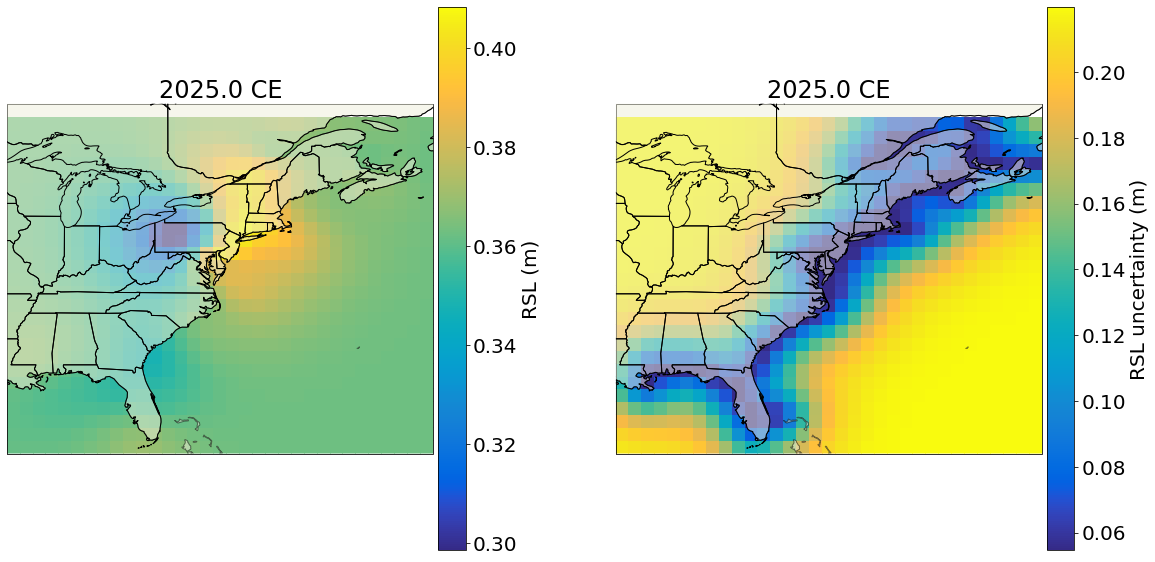

In [5]:
lat_matrix = np.arange(np.min(US_site_coord[:,0])-2,np.max(US_site_coord[:,0])+2,1)
lon_matrix = np.arange(np.min(US_site_coord[:,1])-2,np.max(US_site_coord[:,1])+2,1)
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
pred_matrix = PSTHM.gen_pred_matrix([2025],lat_matrix,lon_matrix)
pred_matrix2 = PSTHM.gen_pred_matrix([1900],lat_matrix,lon_matrix)

y_mean, y_var = gpr(pred_matrix, full_cov=True,noiseless=False)
y_mean2, y_var2 = gpr(pred_matrix2, full_cov=True,noiseless=False)

y_std = y_var.diag().sqrt()
parula=nmmn.plots.parulacmap() # for MATLAB's cmap

fig = PSTHM.plot_spatial_rsl_single(pred_matrix,(y_mean-y_mean2)/1000,y_var/1e6,cmap=parula)

A good thing about using different spatio-temporal GP kernels is that we can actually decompose the spatial temporal signal, which is a powerful tool to interpret sea-level change pattern. To implement it, we can simply keep the variance of interested kernel and set other kernels variance to be 0. In this case, each spatio-temporal or temporal kernel's effect on sea-level change can be isolated. Let's start with decompose temporal singal.

In [5]:
site = 40
site_index = np.sum(US_AT_data.iloc[:,4:],axis=1) == np.sum(US_site_coord[site])
test_age = np.arange(1900,2025,1)
pred_matrix = PSTHM.gen_pred_matrix(test_age,US_site_coord[site][0],US_site_coord[site][1])

y_mean, y_var = gpr(pred_matrix, full_cov=True,noiseless=False)

#-----------------define the kernel to decompose-----------------
global_kernel = gpr.kernel.kern0.kern0
regional_linear_kernel = gpr.kernel.kern0.kern1
regional_nl_kernel = gpr.kernel.kern1

#-----------------decompose the kernel-----------------
global_dep,reigonal_linear_dep,regional_nl_dep = PSTHM.decompose_kernels(gpr,pred_matrix,[global_kernel,regional_linear_kernel,regional_nl_kernel])
global_mean,global_var = global_dep
global_std = global_var.diag().sqrt()

regional_linear_mean,regional_linear_var = reigonal_linear_dep
regional_linear_std = regional_linear_var.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_std = regional_nl_var.diag().sqrt()

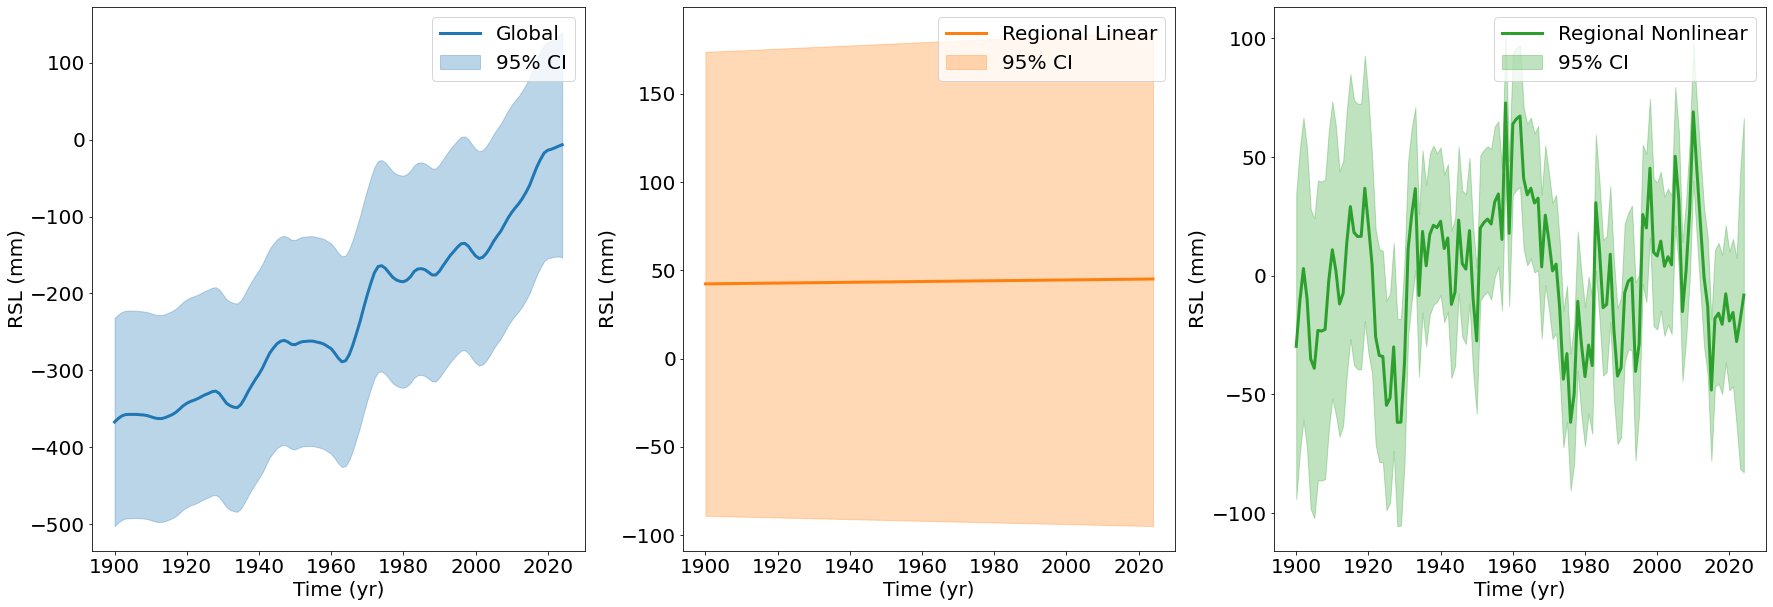

In [6]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(test_age,global_mean.detach().numpy(),'C0',linewidth=3,label='Global')
plt.fill_between(test_age,global_mean.detach().numpy()-2*global_std.detach().numpy(),global_mean.detach().numpy()+2*global_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (mm)')
plt.legend()
plt.subplot(132)
plt.plot(test_age,regional_linear_mean.detach().numpy(),'C1',linewidth=3,label='Regional Linear')
plt.fill_between(test_age,regional_linear_mean.detach().numpy()-2*regional_linear_std.detach().numpy(),regional_linear_mean.detach().numpy()+2*regional_linear_std.detach().numpy(),color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (mm)')
plt.legend()
plt.subplot(133)
plt.plot(test_age,regional_nl_mean.detach().numpy(),'C2',linewidth=3,label='Regional Nonlinear')
plt.fill_between(test_age,regional_nl_mean.detach().numpy()-2*regional_nl_std.detach().numpy(),regional_nl_mean.detach().numpy()+2*regional_nl_std.detach().numpy(),color='C2',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (mm)')
plt.legend();

By decomposing three different components, we can tell more stories about RSL change at this specific tide gauge sites in western Florida, where RSL change here can be explained by a global component (i.e., shared component for every site) showing continuous RSL change perhaps due to themosteric effect, global ice sheet/glacier melting etc. The regional linear component shows a gradual RSL drop, because this site is sitting quite far away from North American Ice Sheet, this RSL drop might not be a result of postglacial rebound, we can interpret more about it if we see the spatial decomposition (details below). Lastly, the regional non-linear component can reflect more short-term RSL change, perhaps caused by ocean dynamic or some short-term climate event. 

Decompose spatial field of RSL change is pretty much the same as temporal field. As all tide gauge sites share the same global component, we don't need to decompose that for spatial field. Therefore, let's just predict the spatial RSL change between 1900 and 2020 for regional linear and regional non-linear GP kernels. 


In [5]:
lat_matrix = np.arange(np.min(US_site_coord[:,0])-2,np.max(US_site_coord[:,0])+2,0.5) # 0.5 degree spatial resolution
lon_matrix = np.arange(np.min(US_site_coord[:,1])-2,np.max(US_site_coord[:,1])+2,0.5)
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
pred_matrix = PSTHM.gen_pred_matrix([2020],lat_matrix,lon_matrix)
pred_matrix2 = PSTHM.gen_pred_matrix([1900],lat_matrix,lon_matrix)
y_mean, y_var = gpr(pred_matrix, full_cov=True,noiseless=False)

#-----------------define the kernel to decompose-----------------
global_kernel = gpr.kernel.kern0.kern0
regional_linear_kernel = gpr.kernel.kern0.kern1
regional_nl_kernel = gpr.kernel.kern1

#-----------------decompose the kernel-----------------
reigonal_linear_dep,regional_nl_dep = PSTHM.decompose_kernels(gpr,pred_matrix,[regional_linear_kernel,regional_nl_kernel])
reigonal_linear_dep2,regional_nl_dep2 = PSTHM.decompose_kernels(gpr,pred_matrix2,[regional_linear_kernel,regional_nl_kernel])

regional_linear_mean,regional_linear_var = reigonal_linear_dep
regional_linear_mean2,regional_linear_var2 = reigonal_linear_dep2
regional_linear_std = regional_linear_var.diag().sqrt()
regional_linear_std2 = regional_linear_var2.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_mean2,regional_nl_var2 = regional_nl_dep2
regional_nl_std = regional_nl_var.diag().sqrt()
regional_nl_std2 = regional_nl_var2.diag().sqrt()

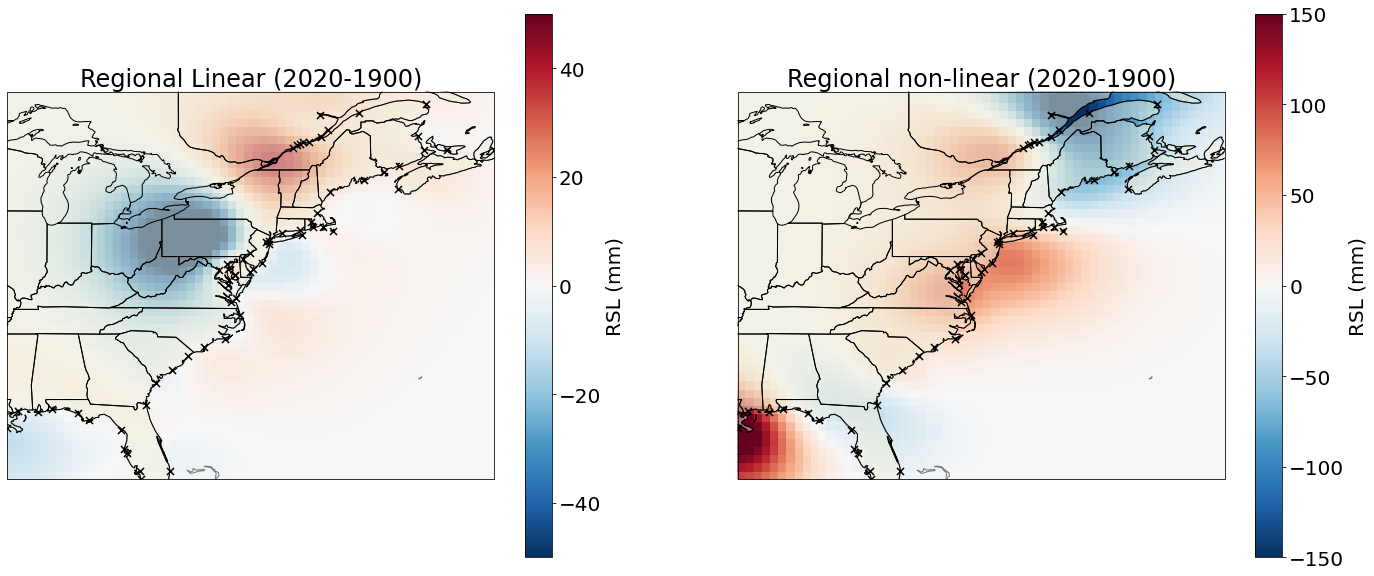

In [6]:
plt.figure(figsize=(24,10))
ax2 = plt.subplot(121,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
ax2.set_extent([np.min(US_site_coord[:,1]),np.max(US_site_coord[:,1]),np.min(US_site_coord[:,0]),np.max(US_site_coord[:,0])])
im = ax2.pcolor(lon_mat,lat_mat,(regional_linear_mean-regional_linear_mean2).detach().numpy().reshape(lat_mat.shape),cmap='RdBu_r',zorder=-1,
                vmax=50,vmin=-50)
plt.colorbar(im,ax=ax2,label='RSL (mm)')
plt.title('Regional Linear (2020-1900)')

ax2.scatter(US_site_coord[:,1],US_site_coord[:,0],c='k',s=50,marker='x',label='TG observation')

ax2 = plt.subplot(122,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
ax2.set_extent([np.min(US_site_coord[:,1]),np.max(US_site_coord[:,1]),np.min(US_site_coord[:,0]),np.max(US_site_coord[:,0])])
ax2.scatter(US_site_coord[:,1],US_site_coord[:,0],c='k',s=50,marker='x',label='TG observation')

im = ax2.pcolor(lon_mat,lat_mat,(regional_nl_mean-regional_nl_mean2).detach().numpy().reshape(lat_mat.shape),cmap='RdBu_r',zorder=-1,vmin=-150,vmax=150)
plt.colorbar(im,ax=ax2,label='RSL (mm)')
plt.title('Regional non-linear (2020-1900)');

### 4. Inferring spatio-temporal sea-level change using RSL data from multiple sea-level sites, incorporating data temporal uncertainty, with multiple spatial and temporal scale GP kernels.

As used for tide gauge data, SP-GP can also be used for paleo sea-level data, which should be straightforward considering what we have done above with PSTHM module. We just need to change input data from tide gauge to paleo RSL data and providing vertical and chronological uncertainty to the model. Let's try it: 


In [3]:
# st = time.time() 

# pyro.clear_param_store()
# #define global temporal kernel as a Matern32
# global_kernel = PSTHM.Matern32(input_dim=1,geo=False)
# global_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(5000.), torch.tensor(1000000.)))
# global_kernel.set_prior("variance", dist.Uniform(torch.tensor(40.**2), torch.tensor(100000.)))

# #define regionally linar spatio-temporal kernel
# regional_linear_temporal_kernel = gp.kernels.Linear(input_dim=1)
# regional_linear_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-12), torch.tensor(1e-2)))
# regional_linear_spatial_kernel = PSTHM.RBF(input_dim=1,geo=True)
# regional_linear_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.1), torch.tensor(0.3)))
# regional_linear_kernel = gp.kernels.Product(regional_linear_temporal_kernel, regional_linear_spatial_kernel)

# #define regionally non-linar spatio-temporal kernel
# regional_nl_temporal_kernel = PSTHM.Matern52(input_dim=1,geo=False)
# regional_nl_temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1000.), torch.tensor(5000.)))
# regional_nl_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.05), torch.tensor(40.**2)))
# regional_nl_spatial_kernel = PSTHM.Matern32(input_dim=1,geo=True)
# regional_nl_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.1), torch.tensor(0.3)))
# regional_nl_kernel = gp.kernels.Product(regional_nl_temporal_kernel, regional_nl_spatial_kernel)

# #define locally non-linar spatio-temporal kernel
# local_nl__temporal_kernel = PSTHM.Matern32(input_dim=1,geo=False)
# local_nl__temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(1000.)))
# local_nl__temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.5**2), torch.tensor(40.**2)))
# local_nl__spatial_kernel = PSTHM.Matern32(input_dim=1,geo=True)
# local_nl__spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.01), torch.tensor(0.1)))
# local_nl_kernel = gp.kernels.Product(local_nl__temporal_kernel, local_nl__spatial_kernel)

# #define whitenoise kernel
# whitenoise_kernel = gp.kernels.WhiteNoise(input_dim=1)
# whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(0.1**2),torch.tensor(100.)))

# #combine all kernels
# combined_sp_kernel = gp.kernels.Sum(regional_linear_kernel,regional_nl_kernel)
# combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,local_nl_kernel)
# combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,whitenoise_kernel)
# combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,global_kernel)

# gpr = PSTHM.GPRegression_V(X.cuda(), y.cuda(), combined_sp_kernel.cuda(),noise=torch.tensor(y_sigma**2).cuda(),jitter=1e-5)
# gpr = gpr.cuda()
# #Empirical bayes optimization, default iteration is 1000
# gpr,track_list = PSTHM.SVI_NI_optm(gpr,x_sigma=age_sigma.cuda(),num_iteration=500,lr=0.3,decay_r = 0.8,step_size=100,gpu=True)

# #predict RSL for each rsl data age 
# # pred_y,_ = gpr(gpr.X, full_cov=True) 

# # #calulate log likelihood of the model prediction
# # fit_likelihood = PSTHM.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
# # print('Log Likelihood {:3.3f}'.format(fit_likelihood))

# et = time.time() # get the end time

# # get the execution time
# elapsed_time = et - st
# print('Execution time: {:3.3f} s'.format( elapsed_time))

# #----Save and load the trained model----
# torch.save(gpr, '../Trained_Models/Holocene_SP_model')
gpr = torch.load('../Trained_Models/Holocene_SP_model').cpu()
gpr.X = gpr.X.cpu()
gpr.y = gpr.y.cpu()
gpr.noise = gpr.noise.cpu()

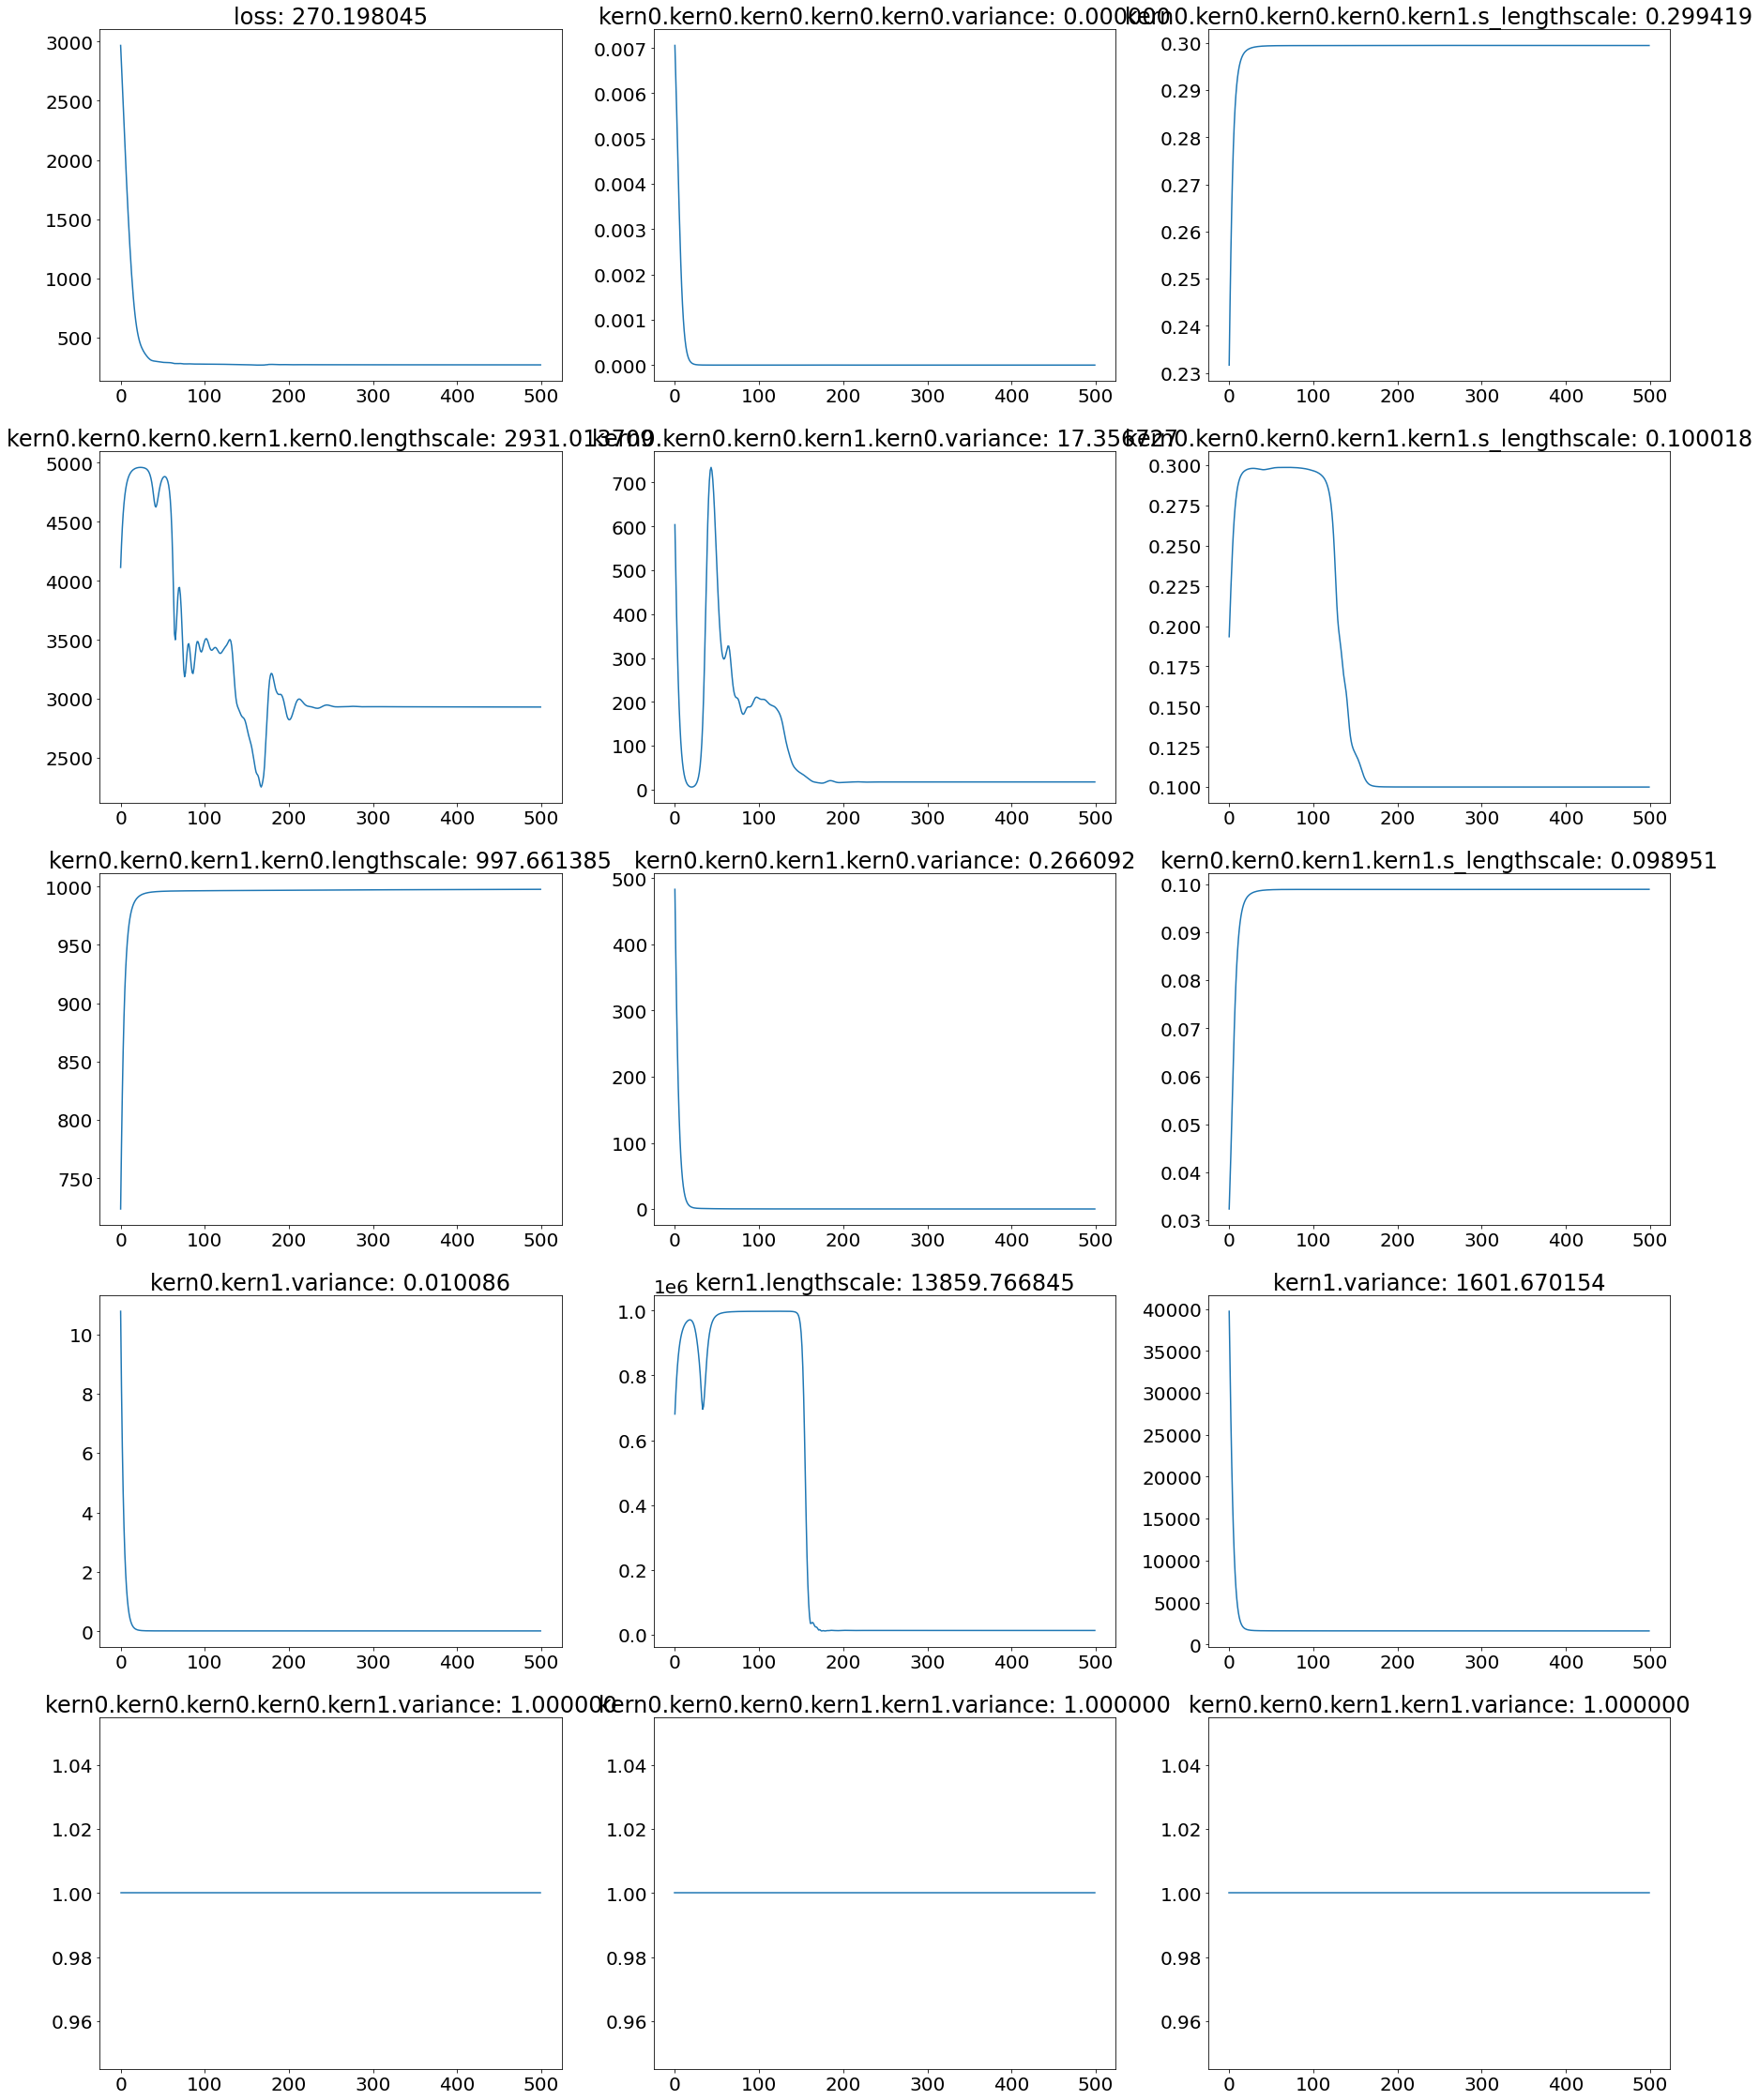

In [13]:

axes = PSTHM.plot_track_list(track_list)

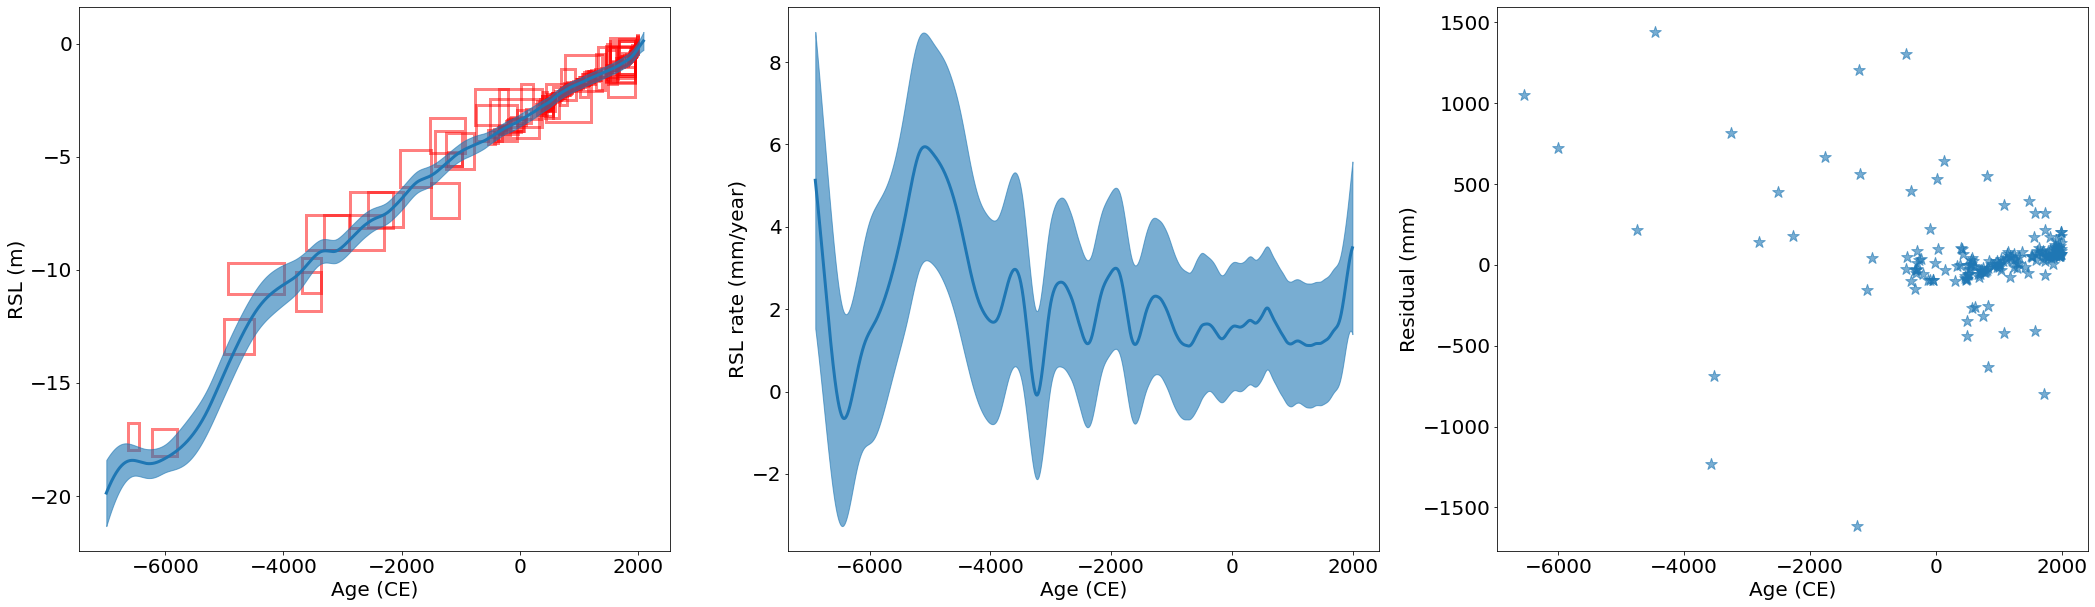

In [14]:
#generate prediction matrix
NJ_index = rsl_region==7
test_age = np.arange(-7000,2100,5)
pred_matrix = PSTHM.gen_pred_matrix(test_age,np.mean(rsl_lat[NJ_index]),np.mean(rsl_lon[NJ_index]))
y_mean, y_var = gpr(pred_matrix.double(), full_cov=True)
y_std = y_var.diag().sqrt()
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.cal_rate_var(test_age,y_var.cpu().detach().numpy(),y_mean.cpu().detach().numpy())

#plot the prediction
axes = PSTHM.plot_tem_regreesion(age[NJ_index],y[NJ_index],age_sigma[NJ_index],y_sigma[NJ_index],test_age,y_mean.detach().numpy(),y_std.detach().numpy(),
                          rsl_time,rsl_rate,rsl_rate_sd )


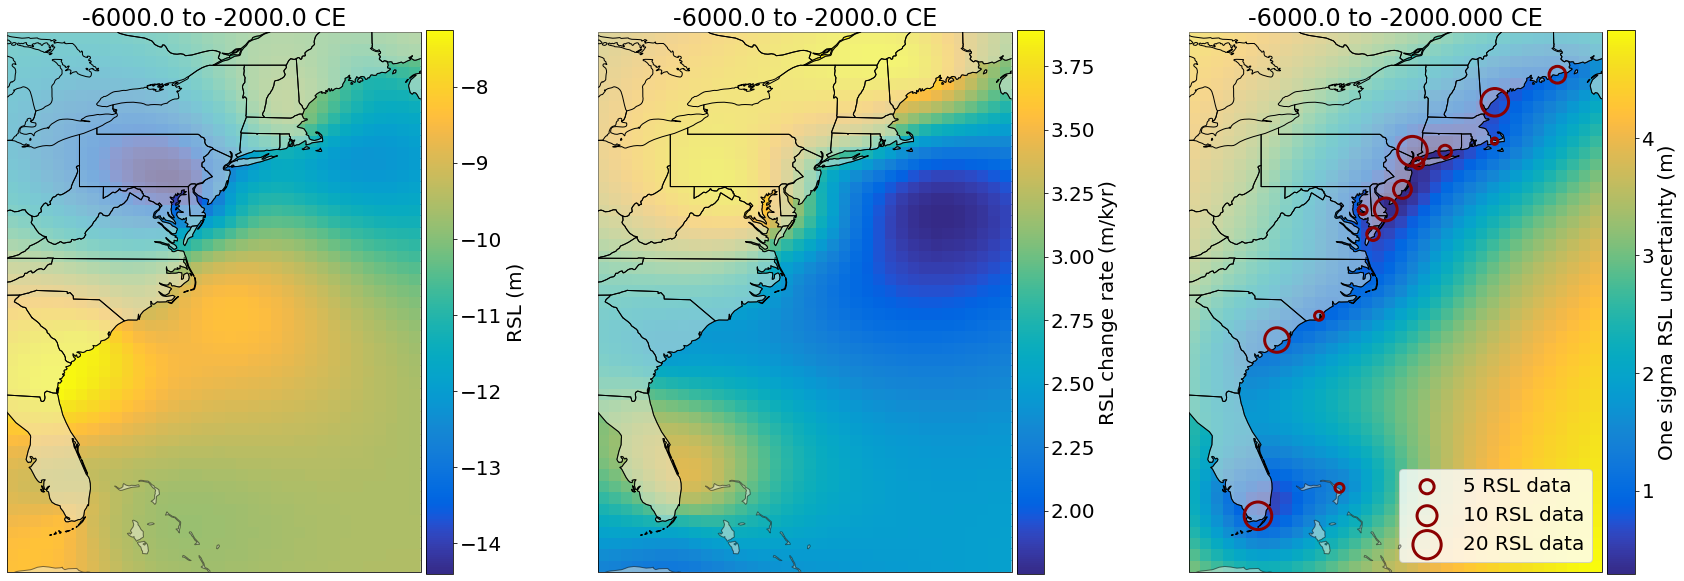

In [4]:
lat_matrix = np.arange(np.min(rsl_lat)-2,np.max(rsl_lat)+2,0.5)
lon_matrix = np.arange(np.min(rsl_lon)-2,np.max(rsl_lon)+2,0.5)
#from 10000 to 8000 with 500 years interval, don't use over small time interval, otherwise the prediction will be very slow
#and the required RAM will be pretty large 
time_mat = np.arange(-6000,-1900,4000) 
pred_matrix = PSTHM.gen_pred_matrix(time_mat,lat_matrix,lon_matrix)

y_mean, y_var = gpr(pred_matrix, full_cov=True)

PSTHM.plot_spatial_rsl_range(pred_matrix,y_mean,y_var,rsl_lon,rsl_lat,age,rsl_region,cmap=parula,plot_site=True)


In [4]:
NJ_index = rsl_region==7
test_age = np.arange(-10000,2100,10)
pred_matrix = PSTHM.gen_pred_matrix(test_age,np.mean(rsl_lat[NJ_index]),np.mean(rsl_lon[NJ_index]))
y_mean, y_var = gpr(pred_matrix, full_cov=True)

#-----------------define the kernel to decompose-----------------
global_kernel = gpr.kernel.kern1
regional_linear_kernel = gpr.kernel.kern0.kern0.kern0.kern0
regional_nl_kernel = gpr.kernel.kern0.kern0.kern0.kern1
local_nl_kernel = gpr.kernel.kern0.kern0.kern1

#-----------------decompose the kernel-----------------
global_dep,reigonal_linear_dep,regional_nl_dep,local_nl_dep = PSTHM.decompose_kernels(gpr,pred_matrix,[global_kernel,regional_linear_kernel,regional_nl_kernel,local_nl_kernel])
global_mean,global_var = global_dep
global_std = global_var.diag().sqrt()

regional_linear_mean,regional_linear_var = reigonal_linear_dep
regional_linear_std = regional_linear_var.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_std = regional_nl_var.diag().sqrt()

local_nl_mean,local_nl_var = local_nl_dep
local_nl_std = local_nl_var.diag().sqrt()


''

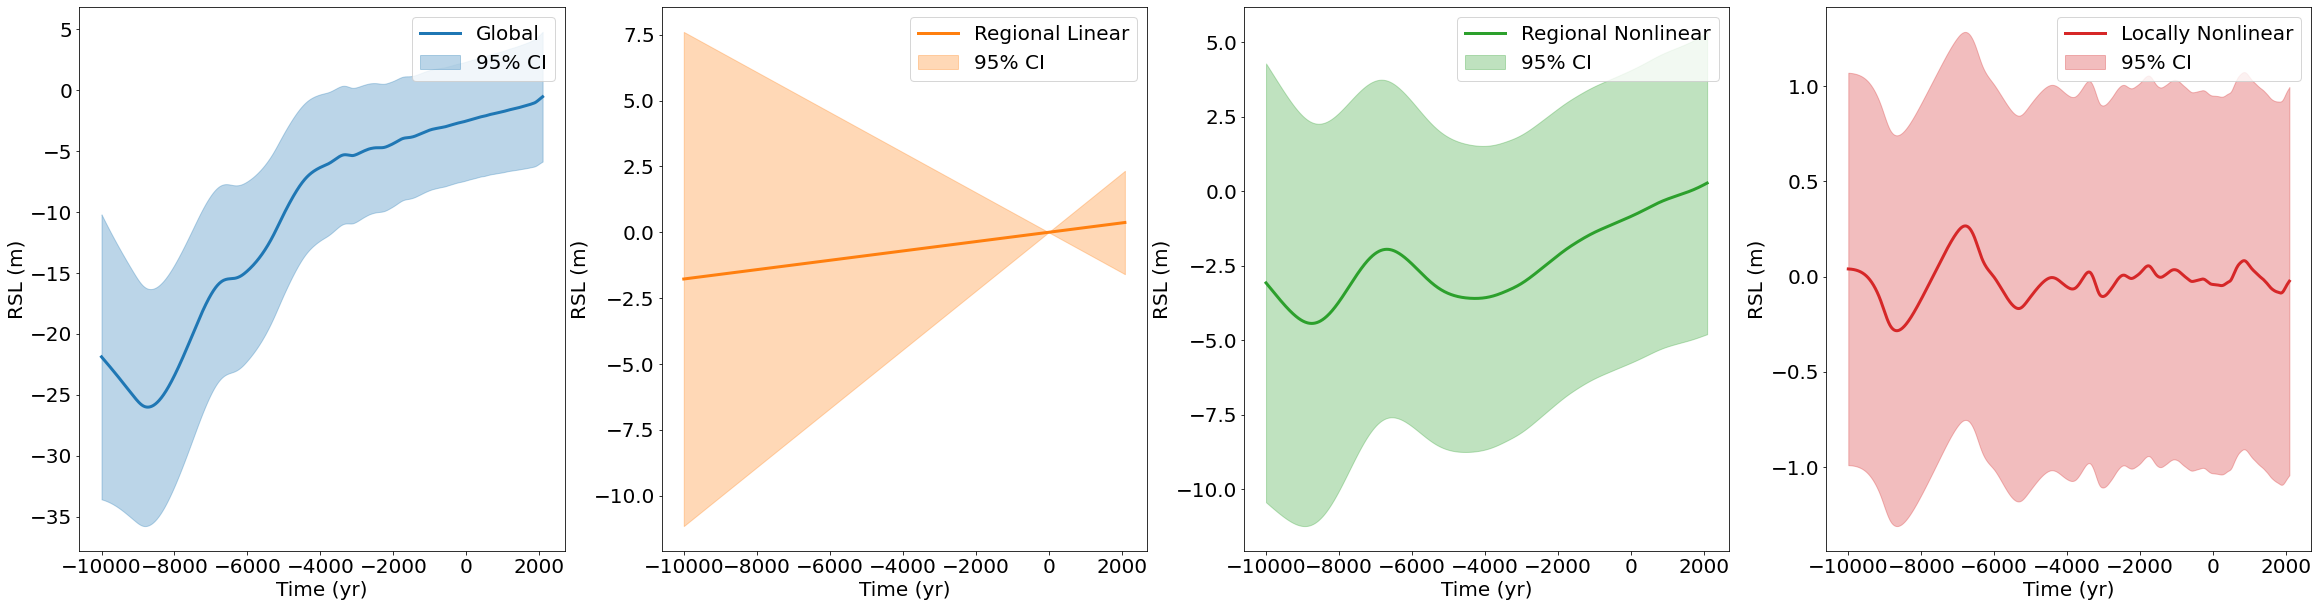

In [5]:
plt.figure(figsize=(40,10))
plt.subplot(141)
plt.plot(test_age,global_mean.detach().numpy(),'C0',linewidth=3,label='Global')
plt.fill_between(test_age,global_mean.detach().numpy()-2*global_std.detach().numpy(),global_mean.detach().numpy()+2*global_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(142)
plt.plot(test_age,regional_linear_mean.detach().numpy(),'C1',linewidth=3,label='Regional Linear')
plt.fill_between(test_age,regional_linear_mean.detach().numpy()-2*regional_linear_std.detach().numpy(),regional_linear_mean.detach().numpy()+2*regional_linear_std.detach().numpy(),color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(143)
plt.plot(test_age,regional_nl_mean.detach().numpy(),'C2',linewidth=3,label='Regional Nonlinear')
plt.fill_between(test_age,regional_nl_mean.detach().numpy()-2*regional_nl_std.detach().numpy(),regional_nl_mean.detach().numpy()+2*regional_nl_std.detach().numpy(),color='C2',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(144)
plt.plot(test_age,local_nl_mean.detach().numpy(),'C3',linewidth=3,label='Locally Nonlinear')
plt.fill_between(test_age,local_nl_mean.detach().numpy()-2*local_nl_std.detach().numpy(),local_nl_mean.detach().numpy()+2*local_nl_std.detach().numpy(),color='C3',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()
;

In [6]:
lat_matrix = np.arange(np.min(rsl_lat)-2,np.max(rsl_lat)+2,0.5)
lon_matrix = np.arange(np.min(rsl_lon)-2,np.max(rsl_lon)+2,0.5)
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
pred_matrix = PSTHM.gen_pred_matrix([-10000],lat_matrix,lon_matrix)
pred_matrix2 = PSTHM.gen_pred_matrix([2000],lat_matrix,lon_matrix)

#-----------------define the kernel to decompose-----------------
global_kernel = gpr.kernel.kern1
regional_linear_kernel = gpr.kernel.kern0.kern0.kern0.kern0
regional_nl_kernel = gpr.kernel.kern0.kern0.kern0.kern1
local_nl_kernel = gpr.kernel.kern0.kern0.kern1

#-----------------decompose the kernel-----------------
reigonal_linear_dep,regional_nl_dep,local_nl_dep = PSTHM.decompose_kernels(gpr,pred_matrix,[regional_linear_kernel,regional_nl_kernel,local_nl_kernel])
reigonal_linear_dep2,regional_nl_dep2,local_nl_dep2 = PSTHM.decompose_kernels(gpr,pred_matrix2,[regional_linear_kernel,regional_nl_kernel,local_nl_kernel])

regional_linear_mean,regional_linear_var = reigonal_linear_dep
regional_linear_mean2,regional_linear_var2 = reigonal_linear_dep2
regional_linear_std = regional_linear_var.diag().sqrt()
regional_linear_std2 = regional_linear_var2.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_mean2,regional_nl_var2 = regional_nl_dep2
regional_nl_std = regional_nl_var.diag().sqrt()
regional_nl_std2 = regional_nl_var2.diag().sqrt()

local_nl_mean,locall_nl_var = local_nl_dep
local_nl_mean2,local_nl_var2 = local_nl_dep2
local_nl_std = local_nl_var.diag().sqrt()
local_nl_std2 = local_nl_var2.diag().sqrt()


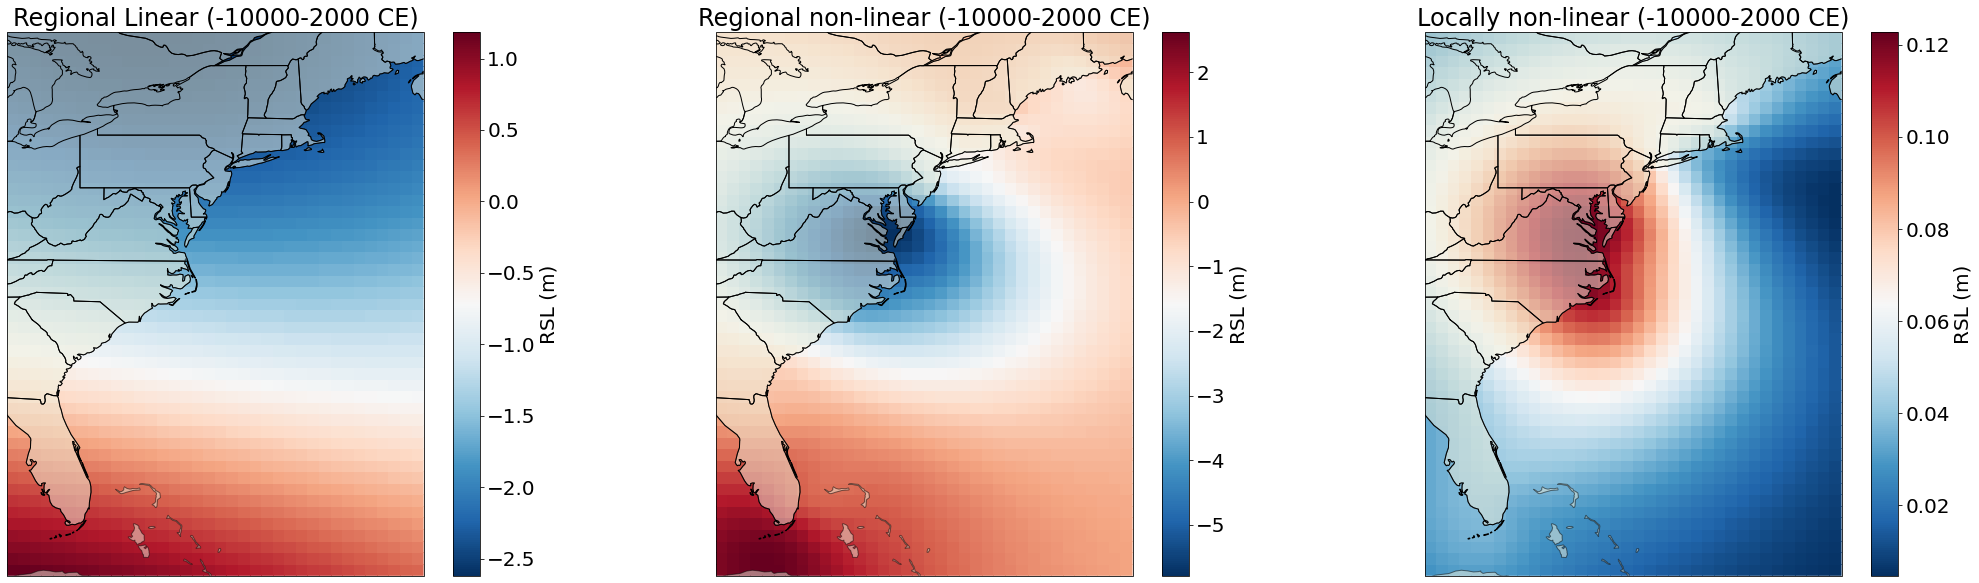

In [7]:
plt.figure(figsize=(36,10))
ax2 = plt.subplot(131,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
im = ax2.pcolor(lon_mat,lat_mat,(regional_linear_mean-regional_linear_mean2).detach().numpy().reshape(lat_mat.shape),cmap='RdBu_r',zorder=-1)
plt.colorbar(im,ax=ax2,label='RSL (m)')
plt.title('Regional Linear (-10000-2000 CE)')


ax2 = plt.subplot(132,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)

im = ax2.pcolor(lon_mat,lat_mat,(regional_nl_mean-regional_nl_mean2).detach().numpy().reshape(lat_mat.shape),cmap='RdBu_r',zorder=-1)
plt.colorbar(im,ax=ax2,label='RSL (m)')
plt.title('Regional non-linear (-10000-2000 CE)')

ax2 = plt.subplot(133,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)

im = ax2.pcolor(lon_mat,lat_mat,(local_nl_mean-local_nl_mean2).detach().numpy().reshape(lat_mat.shape),cmap='RdBu_r',zorder=-1)
plt.colorbar(im,ax=ax2,label='RSL (m)')
plt.title('Locally non-linear (-10000-2000 CE)');